## Clear

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Variables To Set

In [2]:
darkMode = True
PupBlackWhite = True

# Importing Modules 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
import pickle
import scipy.io as sio
from basicFunctions.filters import \
                        butter_bandpass_filter,butter_highpass_filter,butter_lowpass_filter
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from intanRead.IntanRaw_read_data import IntanRaw_read_data

from mainFunctions.loadDataFilePath import loadDataFilePath
from mainFunctions.readDigitalChannels import readDigitalChannels
from mainFunctions.readAnalogChannels import readAnalogChannels
from mainFunctions.stimOnsetExtraction import stimOnsetExtraction
from mainFunctions.loadSpikesFromPhy import loadSpikesFromPhy
from mainFunctions.neuronsInfoExtraction import neuronsInfoExtraction
from mainFunctions.pupilSizeReading import pupilSizeReading
from mainFunctions.spikeTriggeredAvgPupilSize import spikeTriggeredAvgPupilSize
from mainFunctions.neuronVisualResponse import neuronVisualResponse
from mainFunctions.tuningCurveAndOSI import tuningCurveAndOSI
from mainFunctions.extractLowAndHighArousalTrials import extractLowAndHighArousalTrials
from mainFunctions.allTrialsResponses import allTrialsResponses
from mainFunctions.responseChangeByAlertness import responseChangeByAlertness
from mainFunctions.bestOrienationResponseChangeByAlertness\
                    import bestOrienationResponseChangeByAlertness
from mainFunctions.noiseCorrBetweenAlertAndNonAlertTrials\
                    import noiseCorrBetweenAlertAndNonAlertTrials
from mainFunctions.powerSpectrumSingleChannel import powerSpectrumSingleChannel
from mainFunctions.estimatedL5chnnael import estimatedL5chnnael
from mainFunctions.exctractAlertAndNonAlertPeriods\
                    import exctractAlertAndNonAlertPeriods
from mainFunctions.spectrumCompareAlertNonAlert\
                    import spectrumCompareAlertNonAlert



if darkMode:
        plt.style.use('dark_background')

## Getting the data file

In [9]:
dataFileAdd, dataFileBaseFolder, infoFileAdd = loadDataFilePath\
                            ("X:\MS\Pups_for_CW_Preprocessing")
#take the amplifierReorderRereferencedHighPass.dat file

## Reading the info file

In [10]:
infoResult = IntanRaw_read_data(infoFileAdd)
channelsNo = len(infoResult['amplifier_channels'])
ADC_channelsNo = len(infoResult['board_adc_channels'])
fs = int(infoResult['frequency_parameters']['board_dig_in_sample_rate'])


Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 64 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 8 board ADC channels.
Found 16 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 20.00 kS/s.
Done!  Elapsed time: 0.1 seconds


### Reading the digital data file

In [11]:
stimID, firstBeforeStimTagSampleNo, lastStimTagSampleNo = readDigitalChannels(dataFileBaseFolder)

if PupBlackWhite:
    stimID = np.ones(stimID.shape)

### Reading the analog data file to extract raw photoDiodeSignal and raw camerastrob

In [12]:
photoDiodeSignal, cameraStrobe = readAnalogChannels(dataFileBaseFolder,ADC_channelsNo)

### stimOnset based on the photoDiode Signal

240 : this should be equal to totalTrialNo in the matlab stim presentation m-file (load the workspace in matlab)


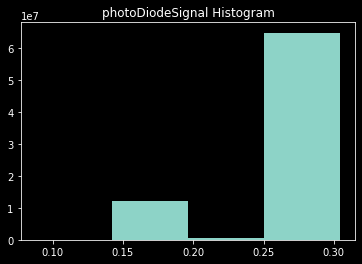

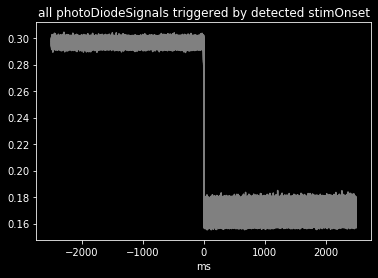

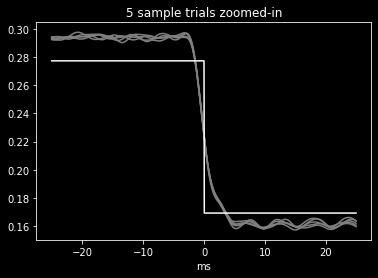

In [13]:
stimOnsetSample = stimOnsetExtraction(photoDiodeSignal,firstBeforeStimTagSampleNo,lastStimTagSampleNo,fs\
                                      ,lowPassfilterBand = 300)

## loading the sorting results from KiloSort-Phy

#### Ctl+s in Phy first!

In [14]:
spikeTime, spikeClusters, SUA_clusters, MUA_clusters = loadSpikesFromPhy(dataFileBaseFolder)

[  9  13  15  19  20  34  35  43  45  46  47  50  56  57  58  59  62  63
  65  68  77  81  82  84  85  86  88  92  97 101 108 112 120 129 133 134
 135 140] these clusters numbers should be the same as the ones that have been asigned as good units in Phy


## Extracting the spike wave-shapes, spont FRs and the channels

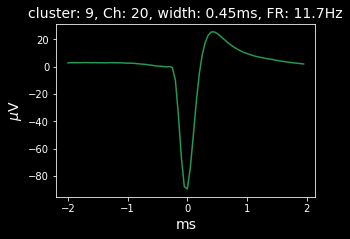

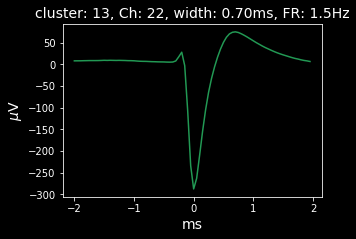

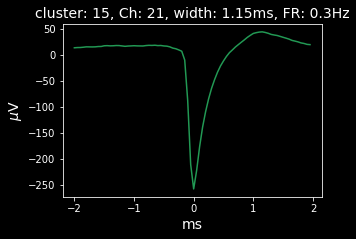

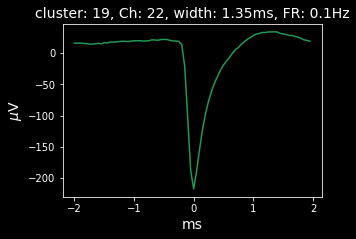

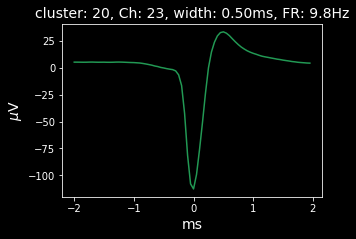

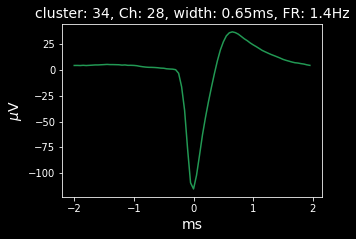

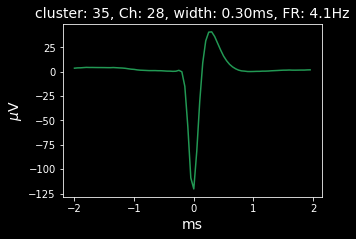

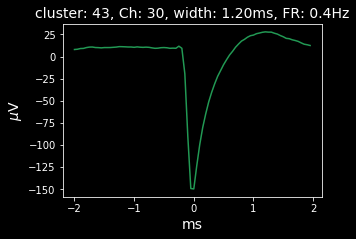

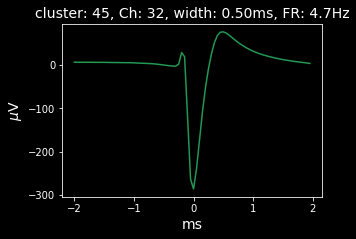

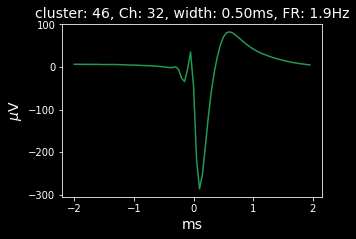

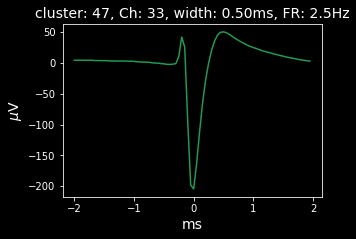

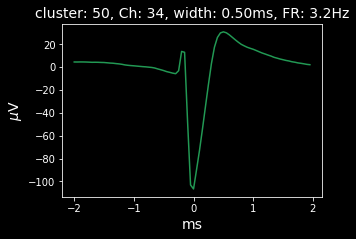

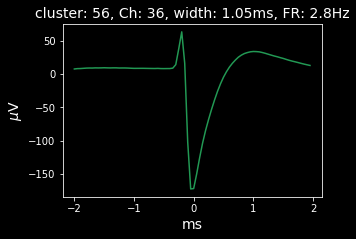

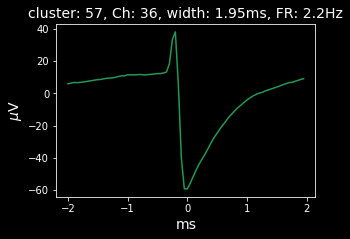

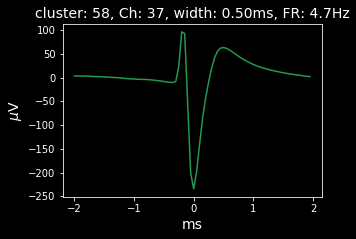

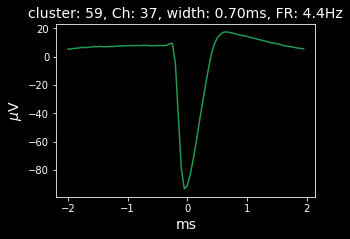

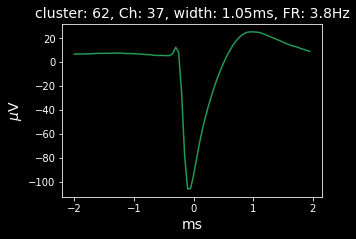

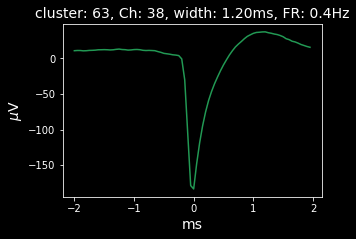

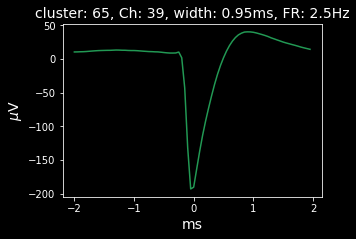

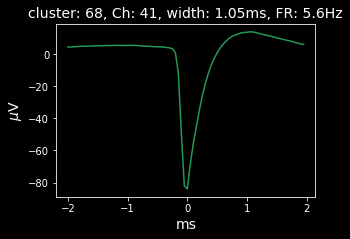

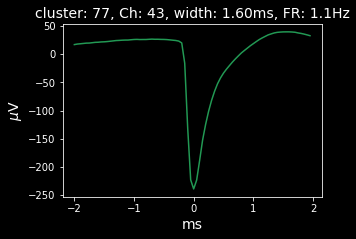

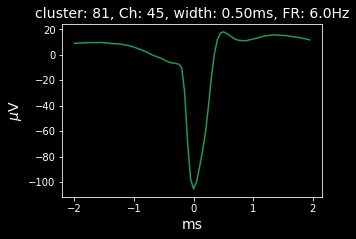

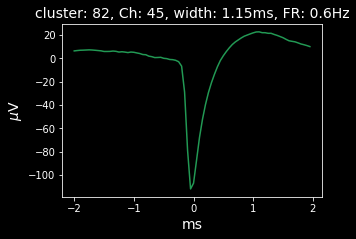

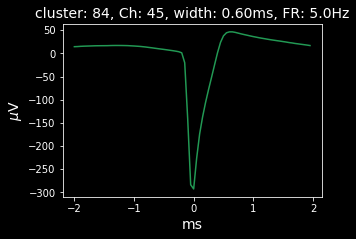

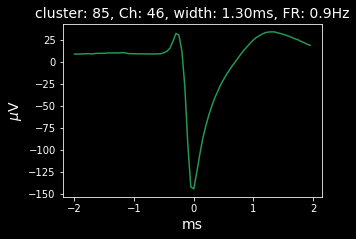

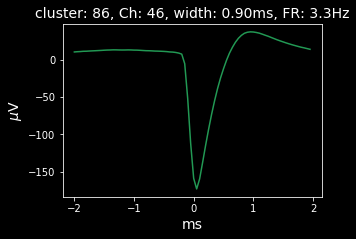

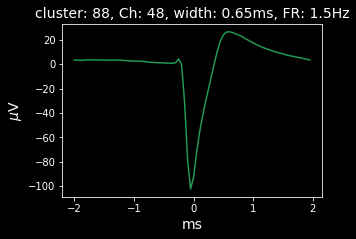

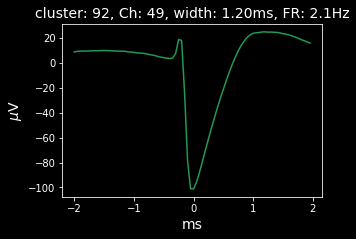

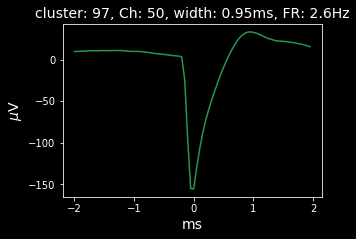

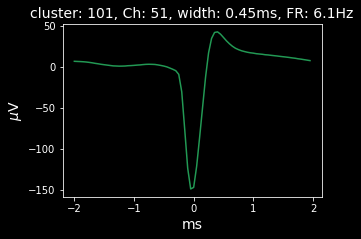

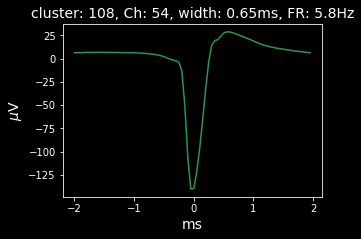

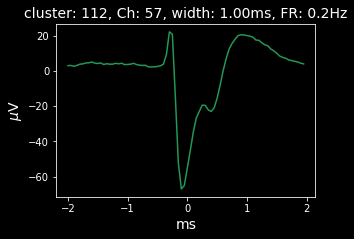

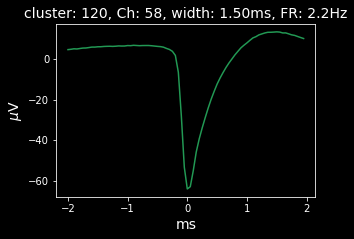

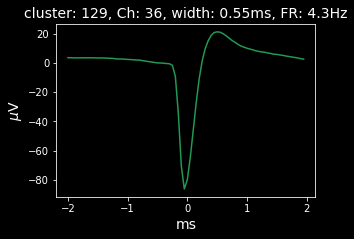

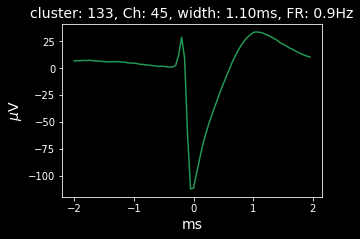

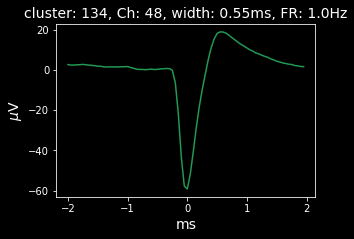

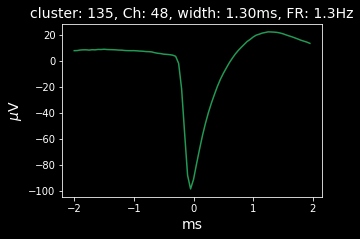

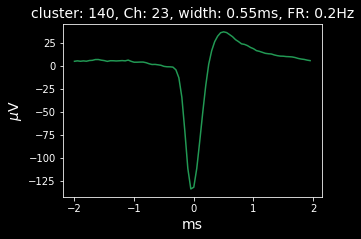

In [15]:
spontFRs, spikeWidthAll, clusterChannel, spikeShapesFiltered, spikeClustersToPlot, recordingDurInMS = \
    neuronsInfoExtraction(dataFileAdd, spikeTime, spikeClusters, SUA_clusters, MUA_clusters, firstBeforeStimTagSampleNo,\
                          fs, spikeTypes = 'SUA')

### visual responsiveness of neurons

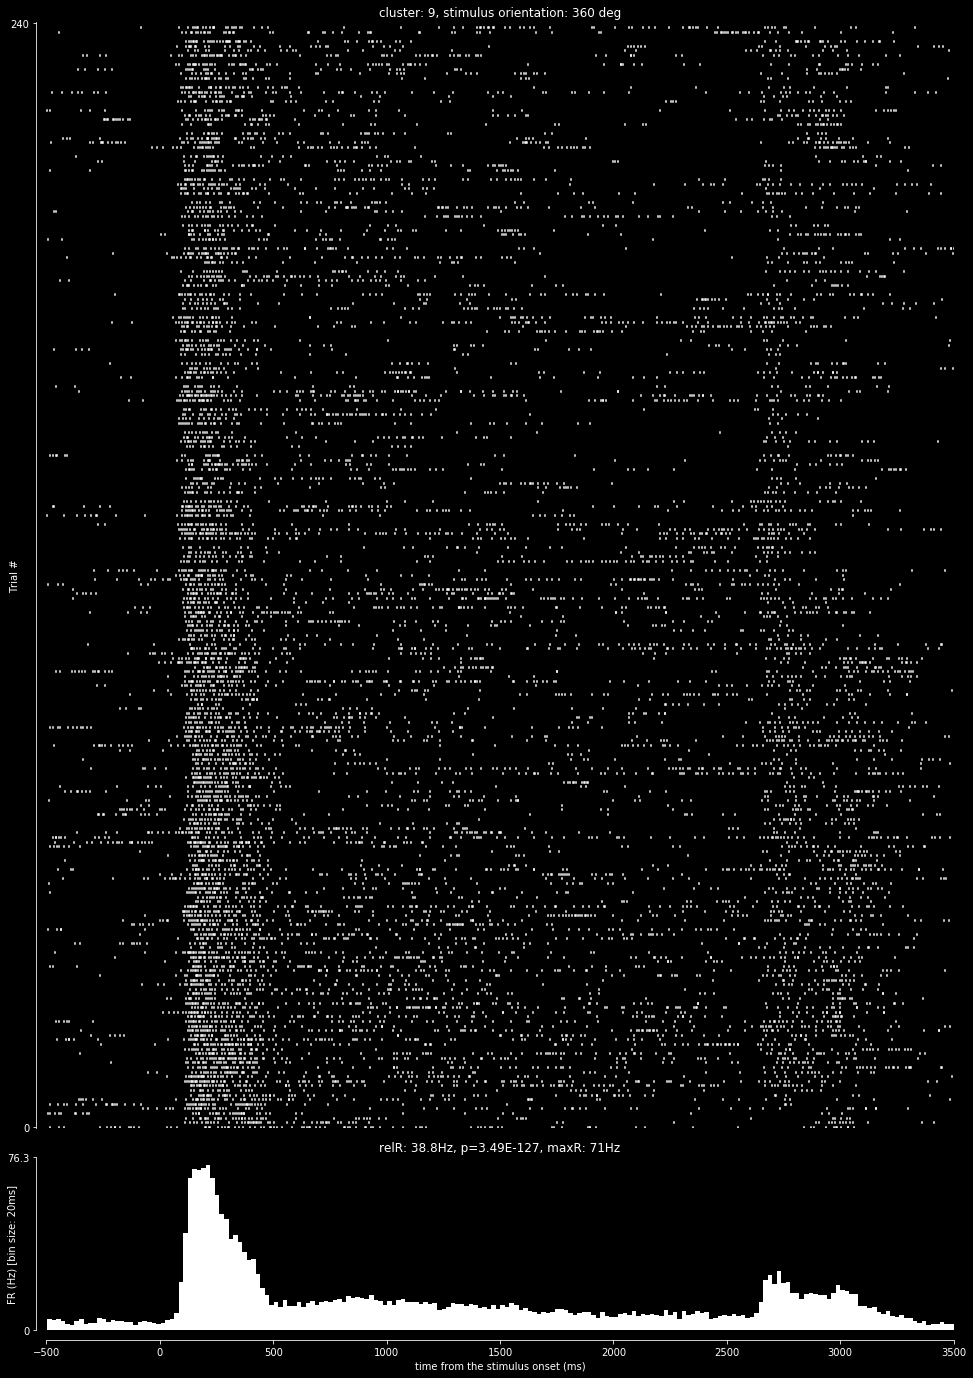

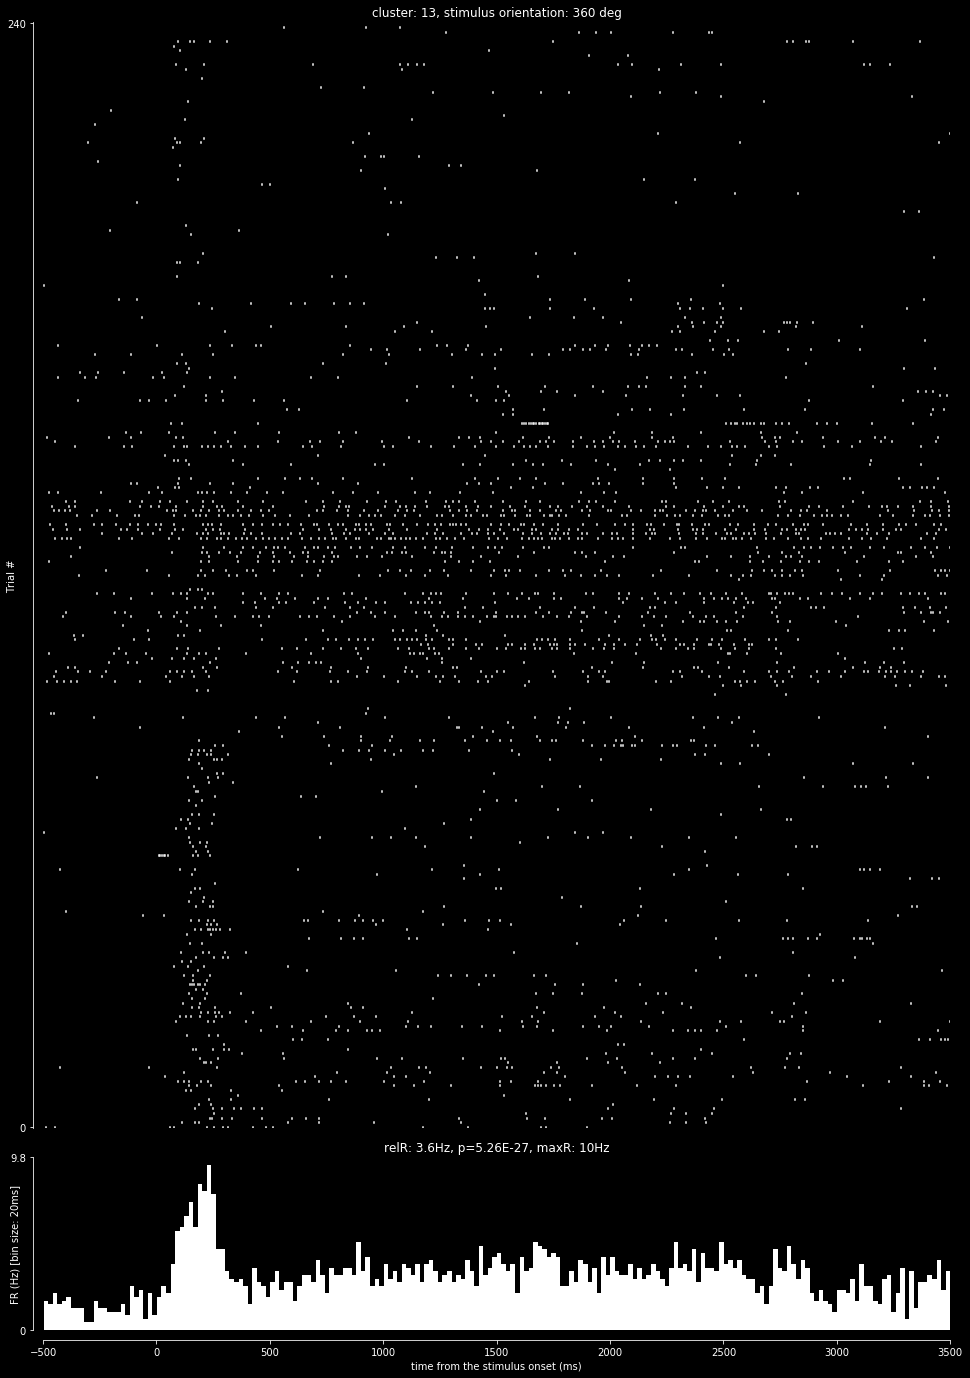

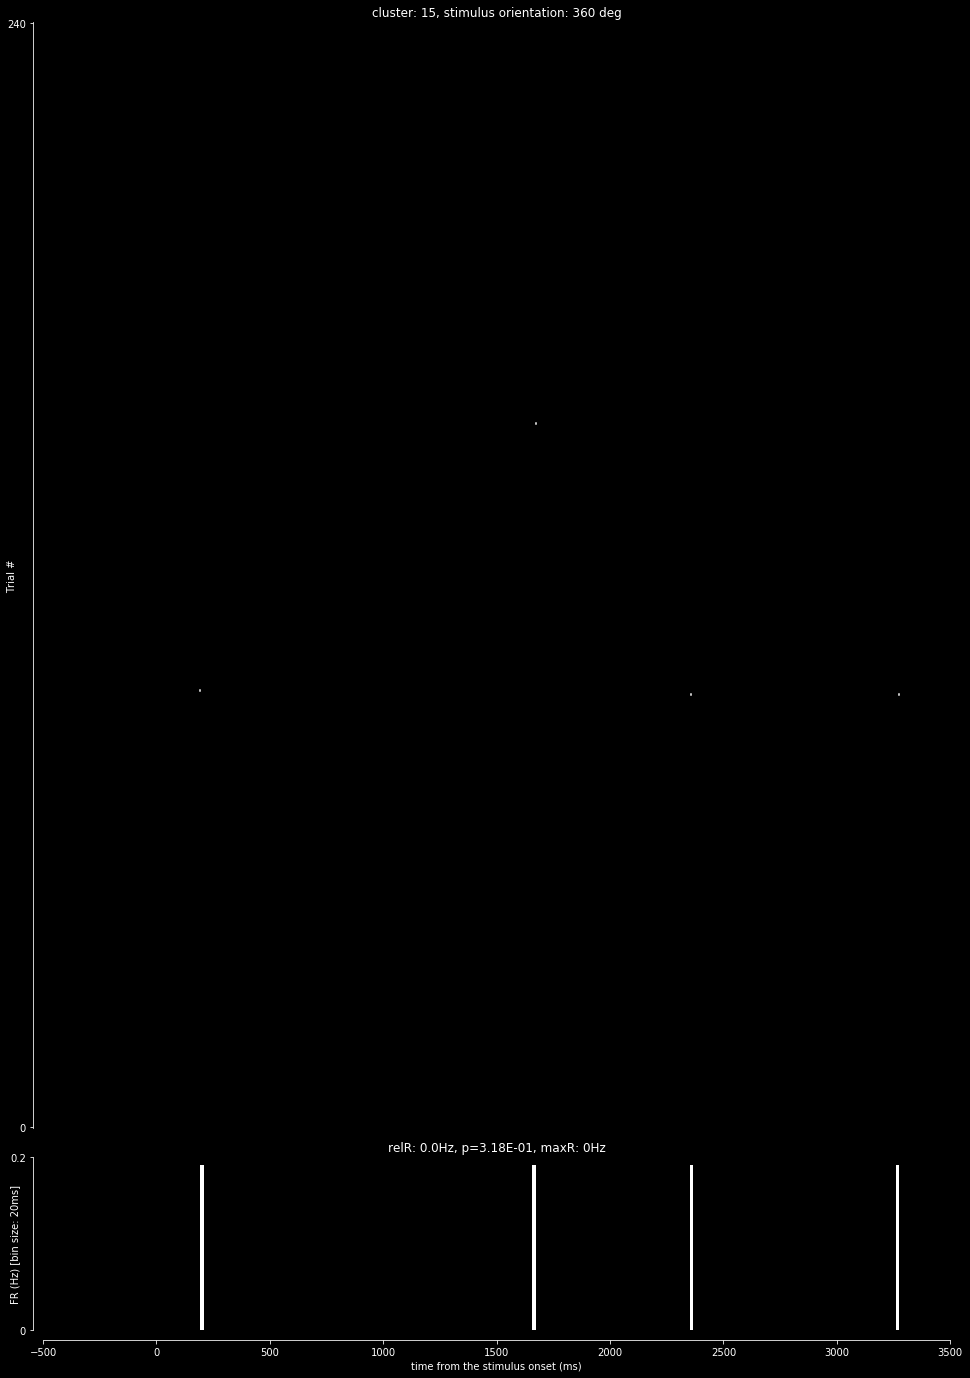

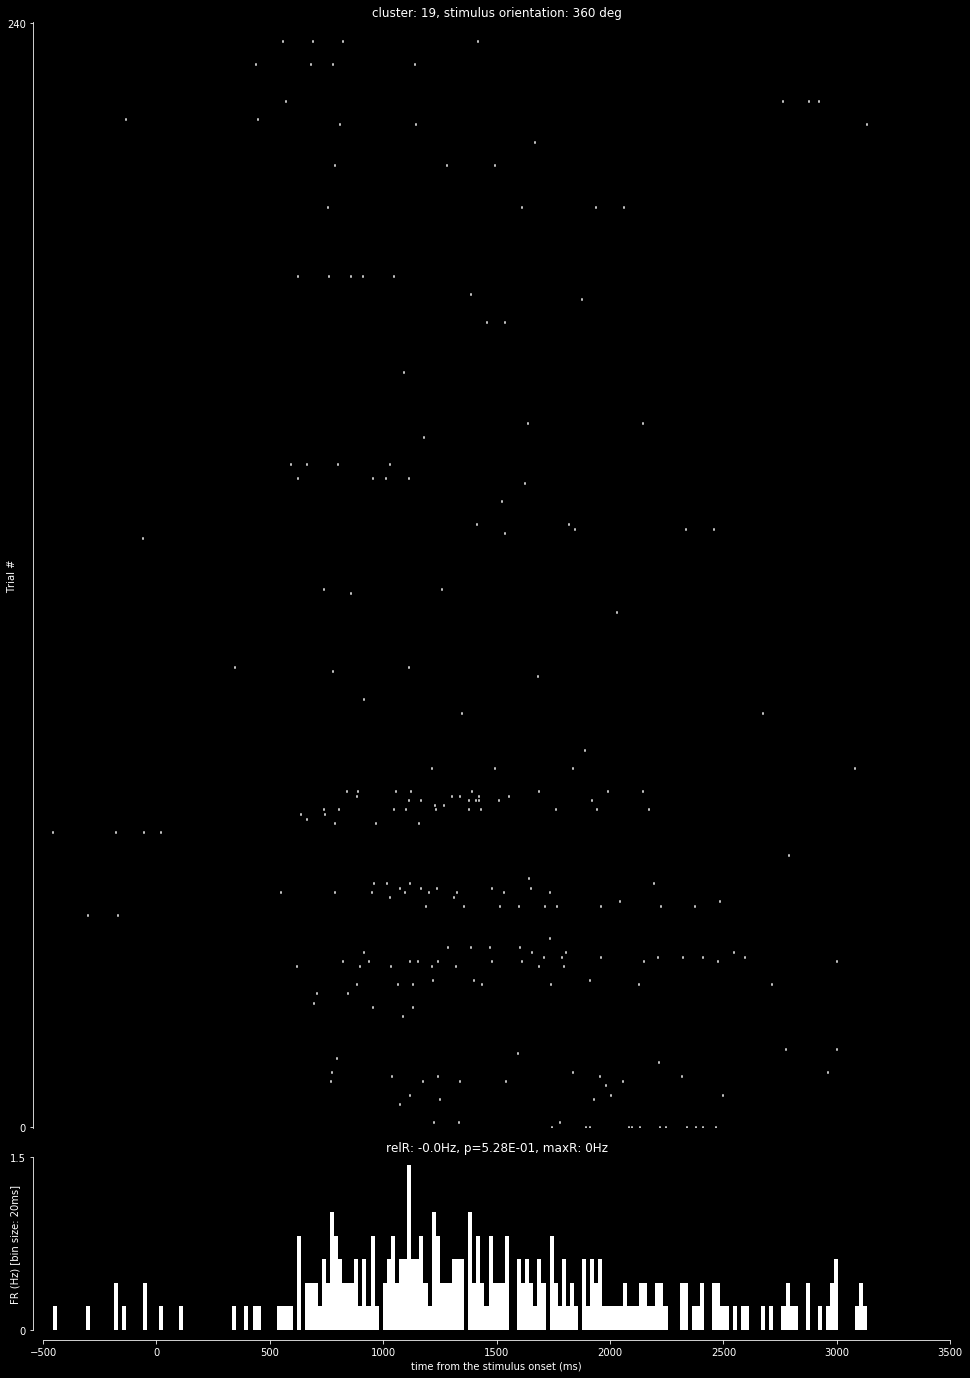

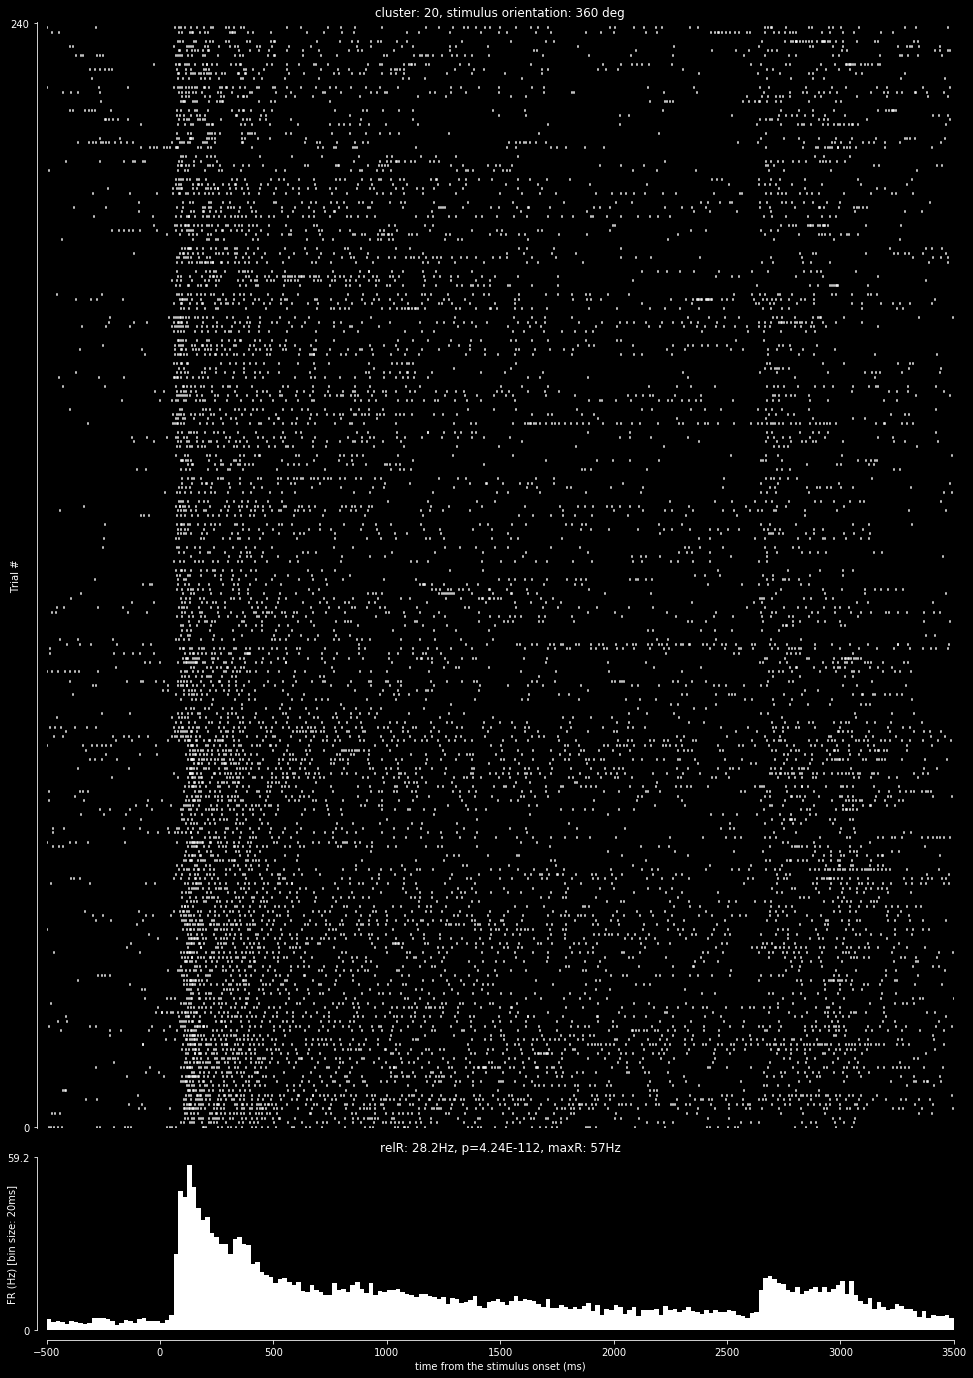

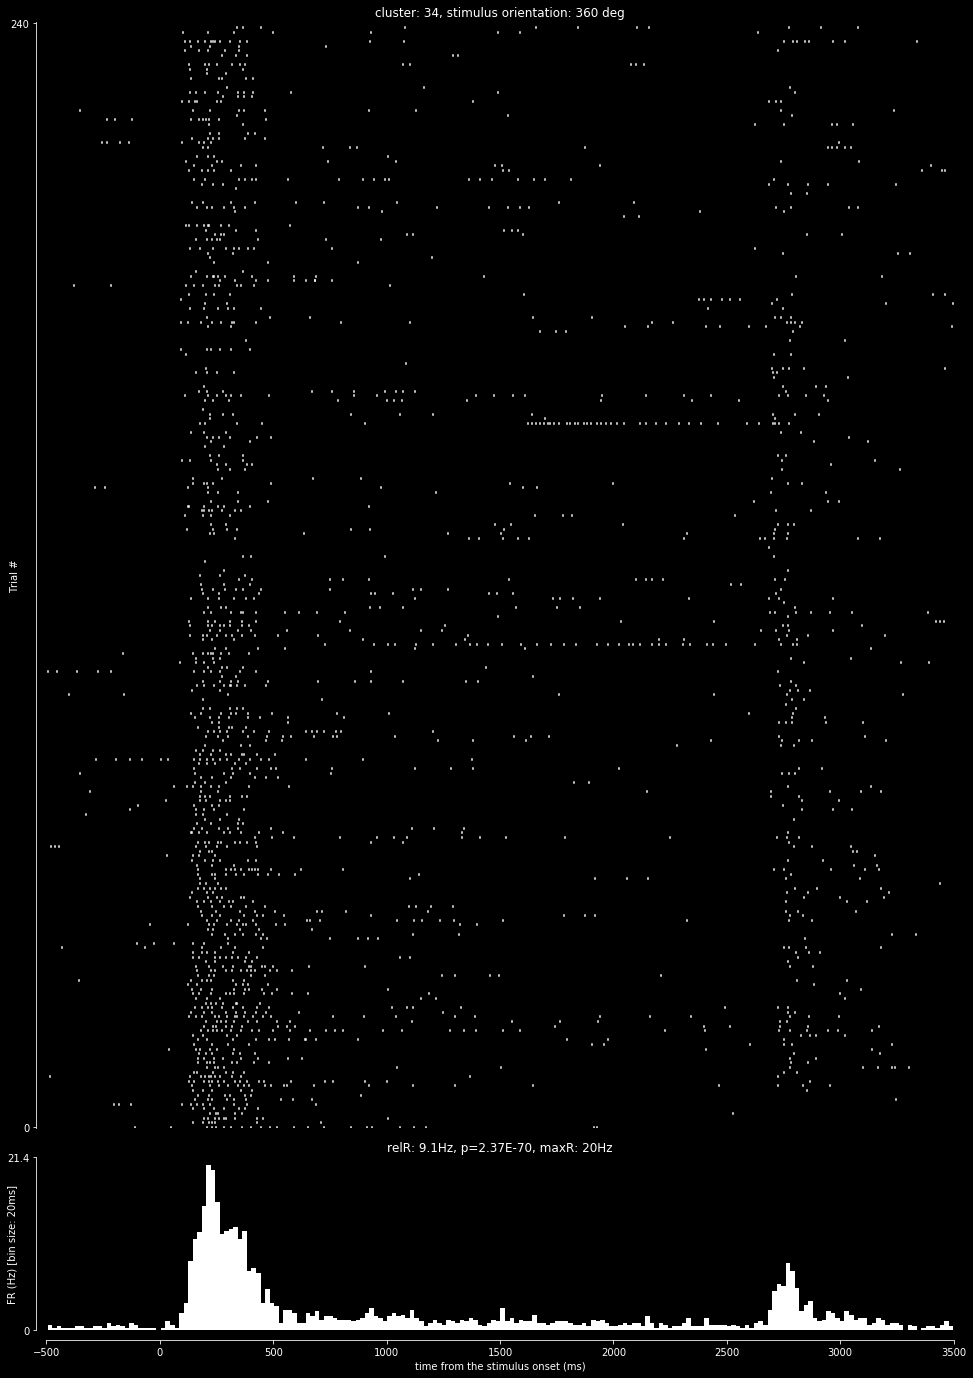

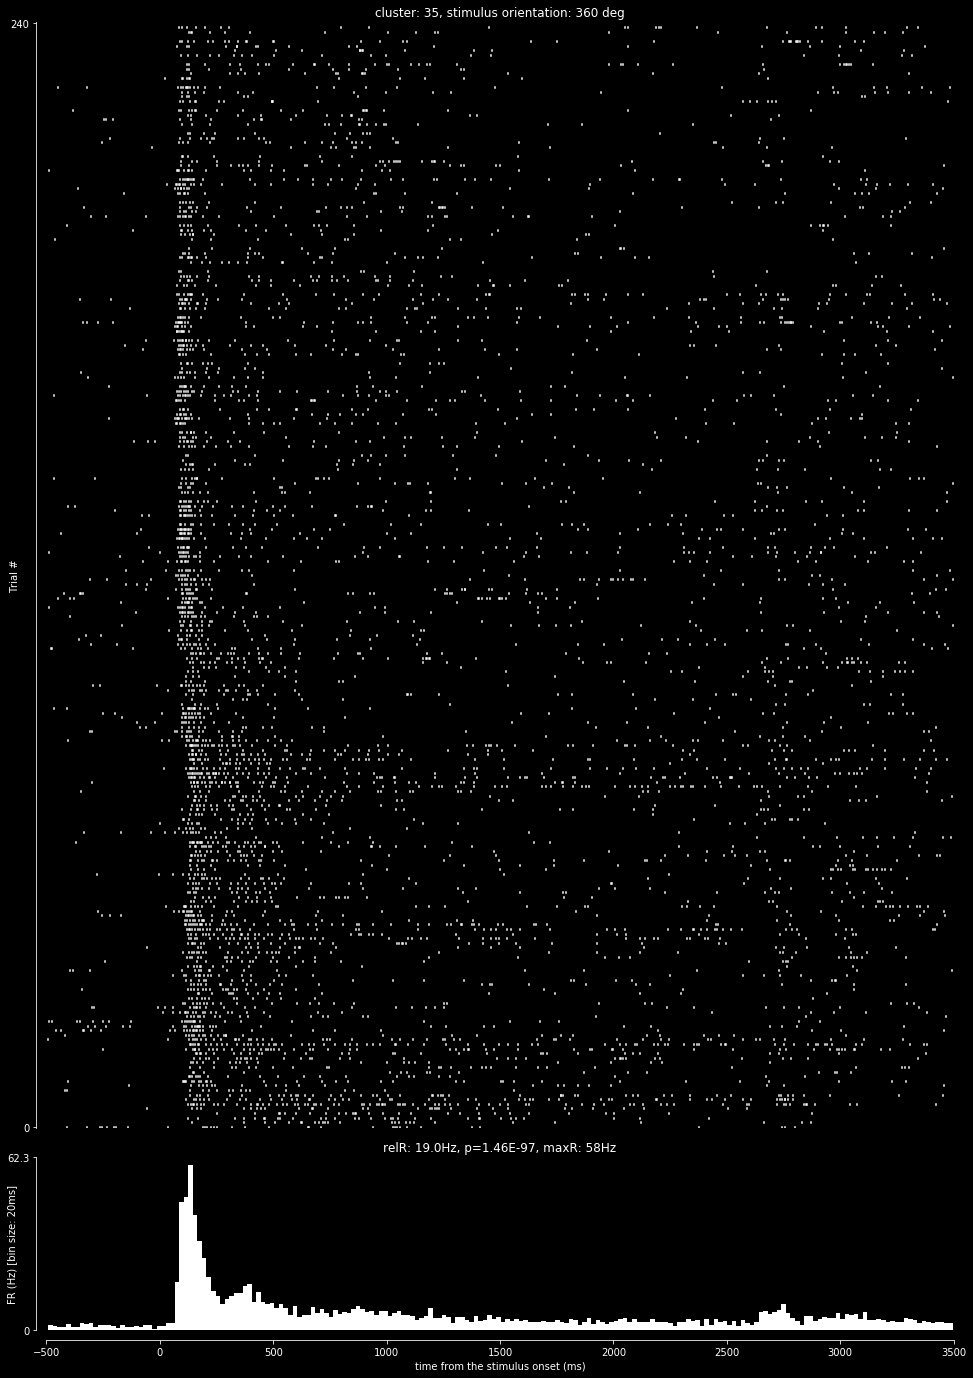

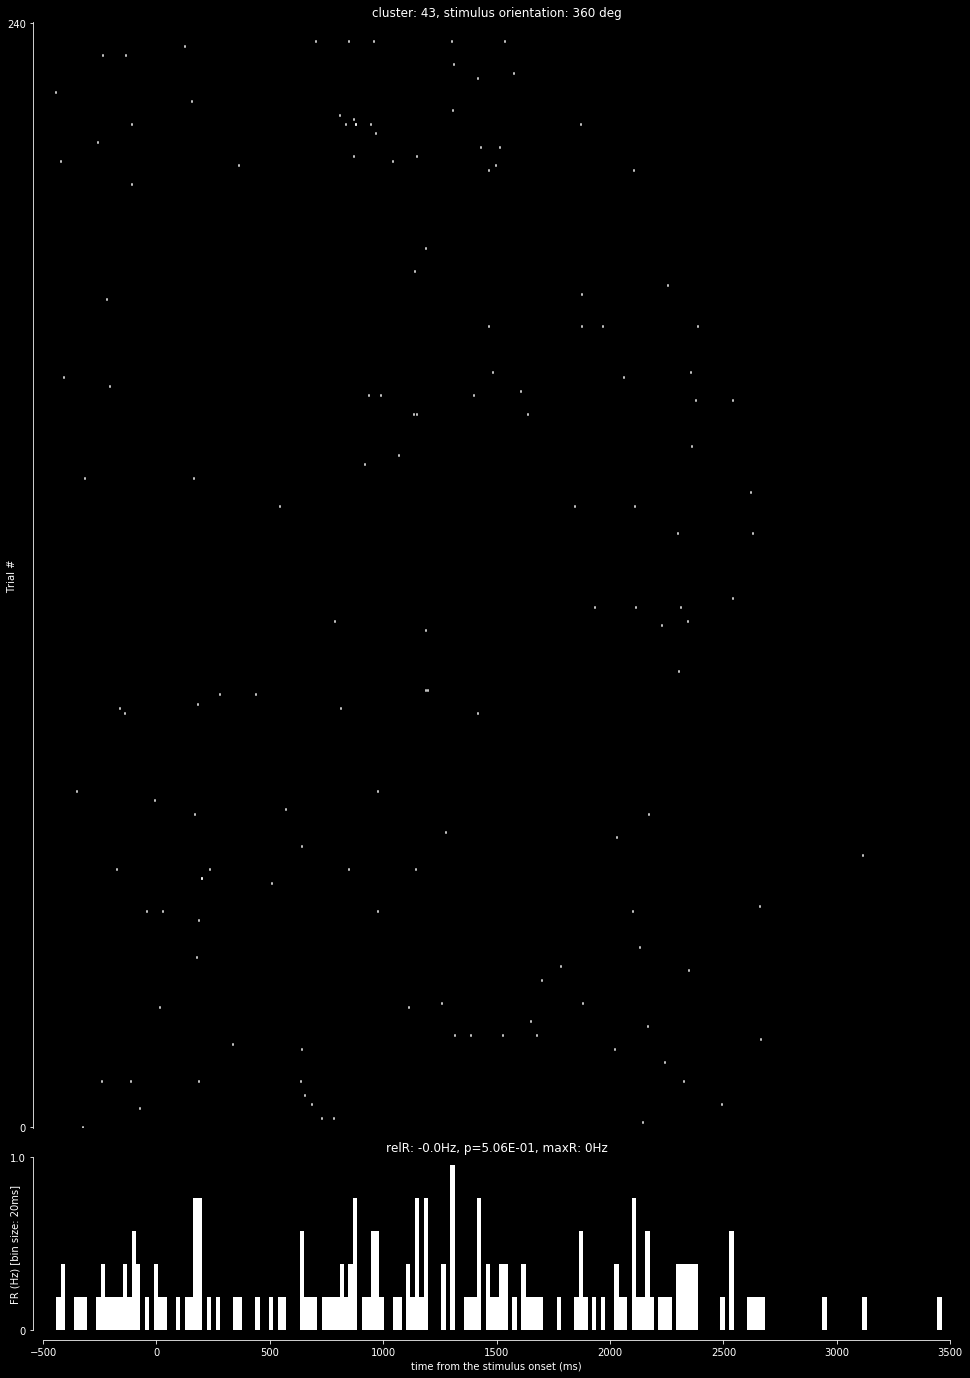

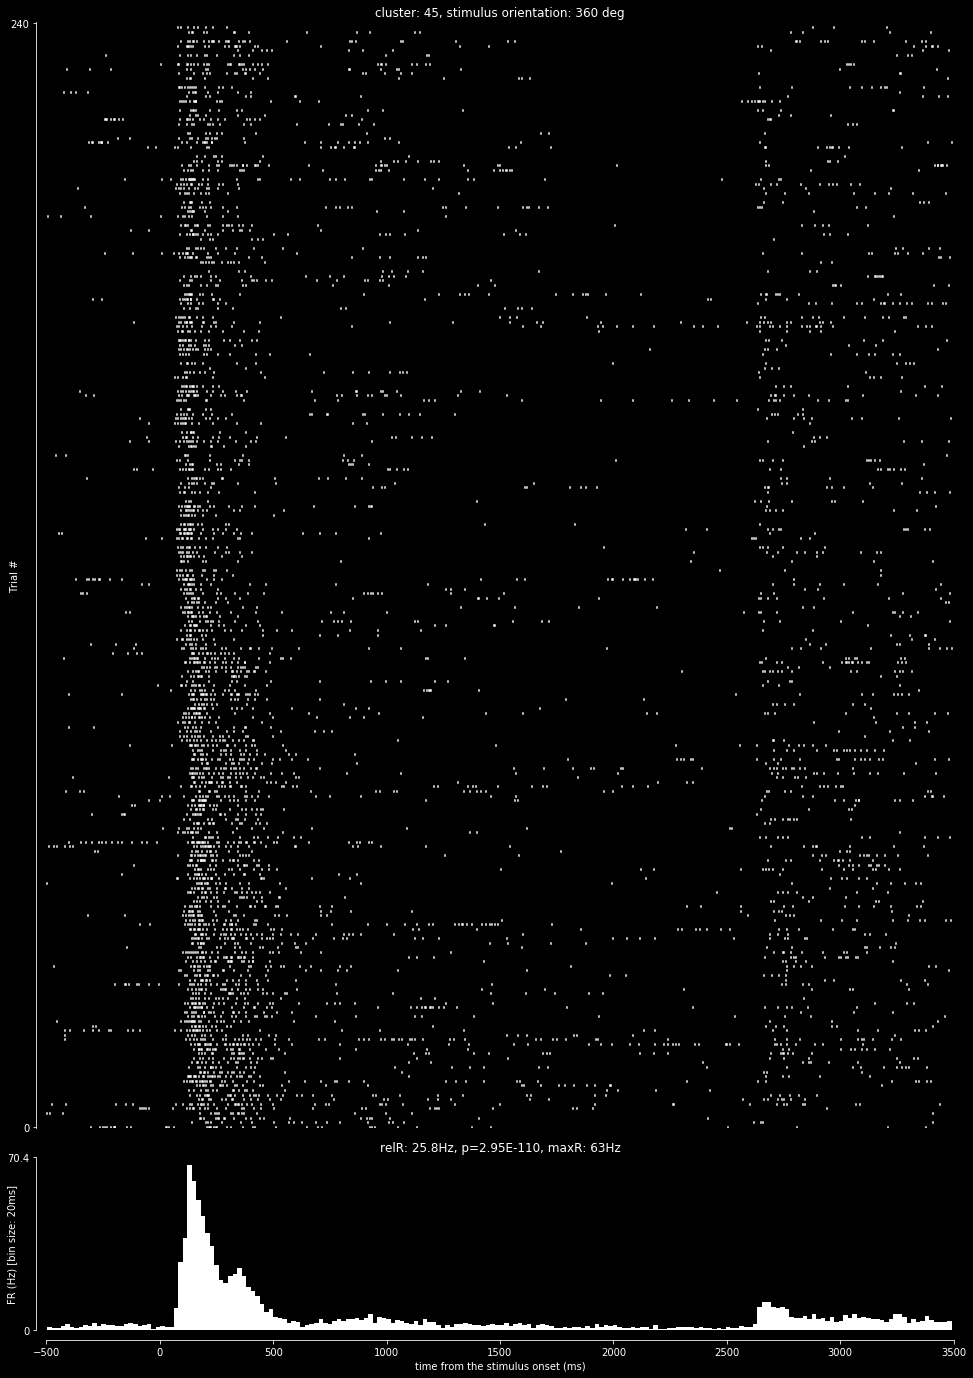

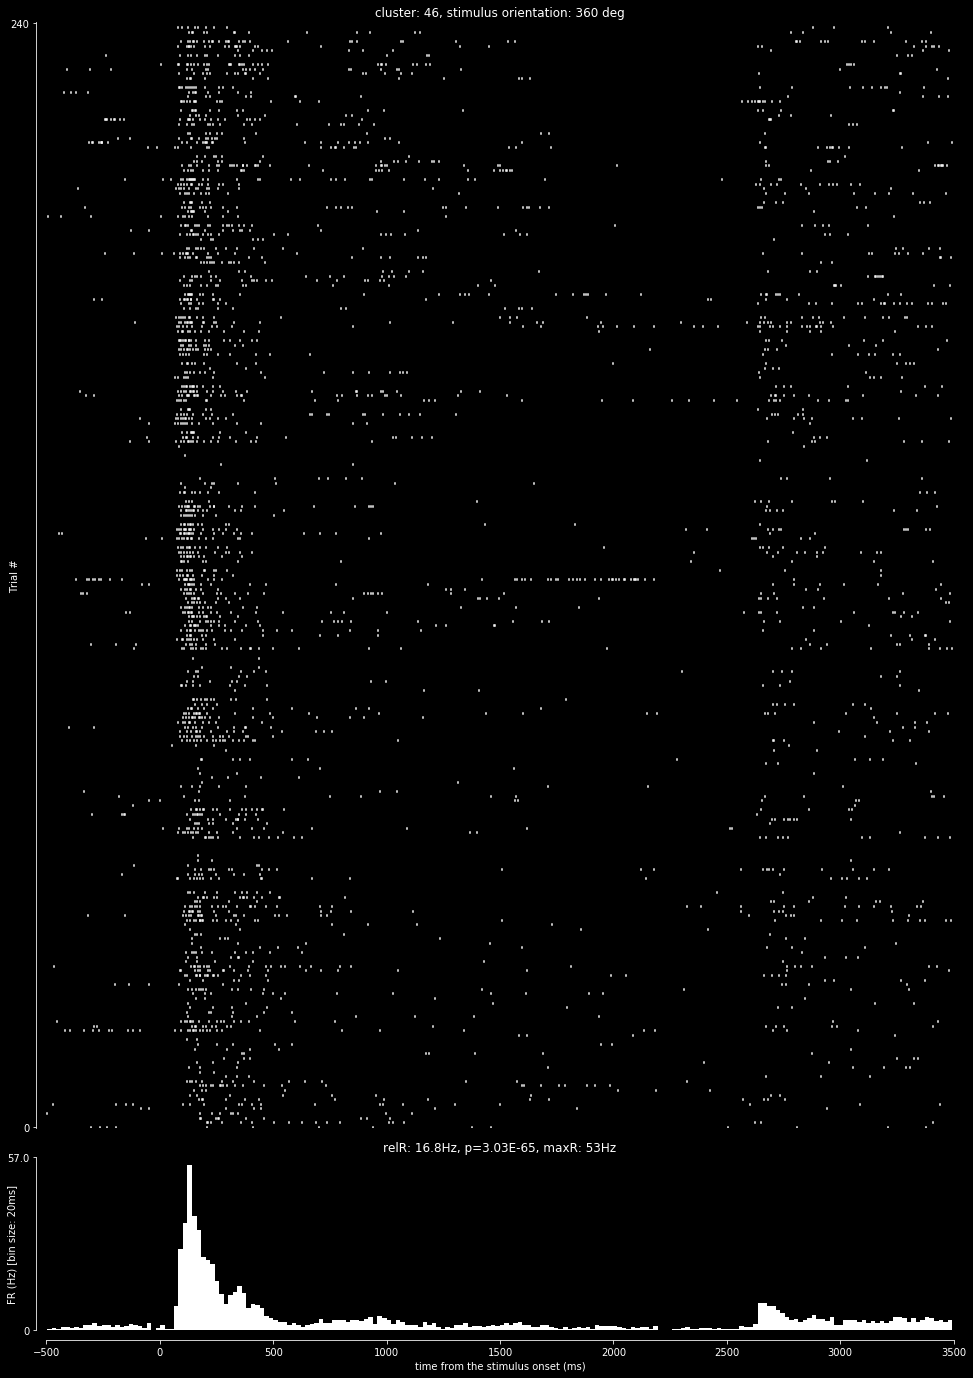

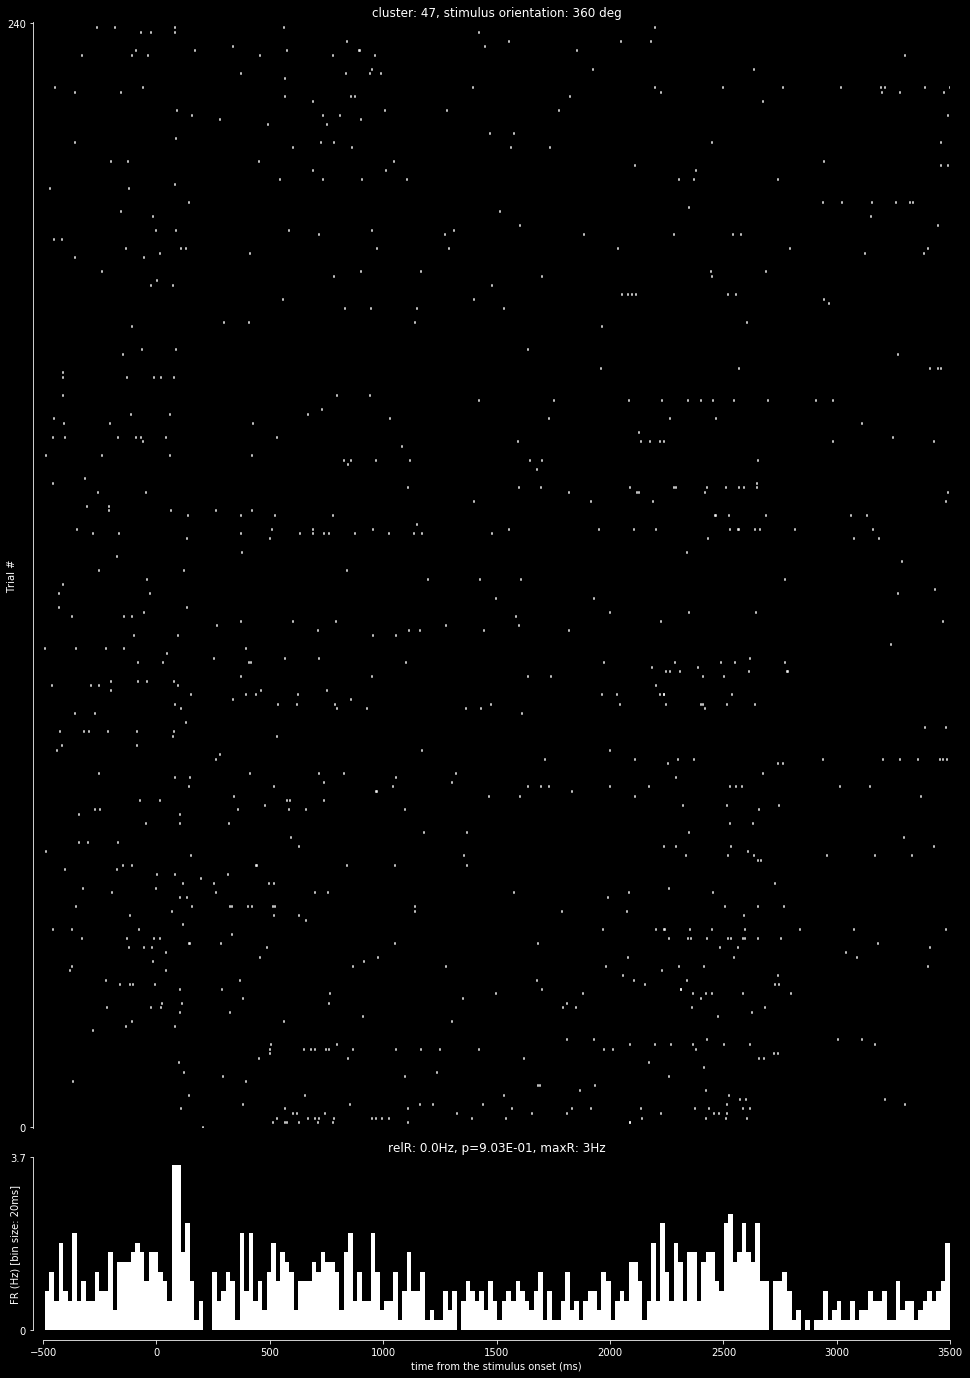

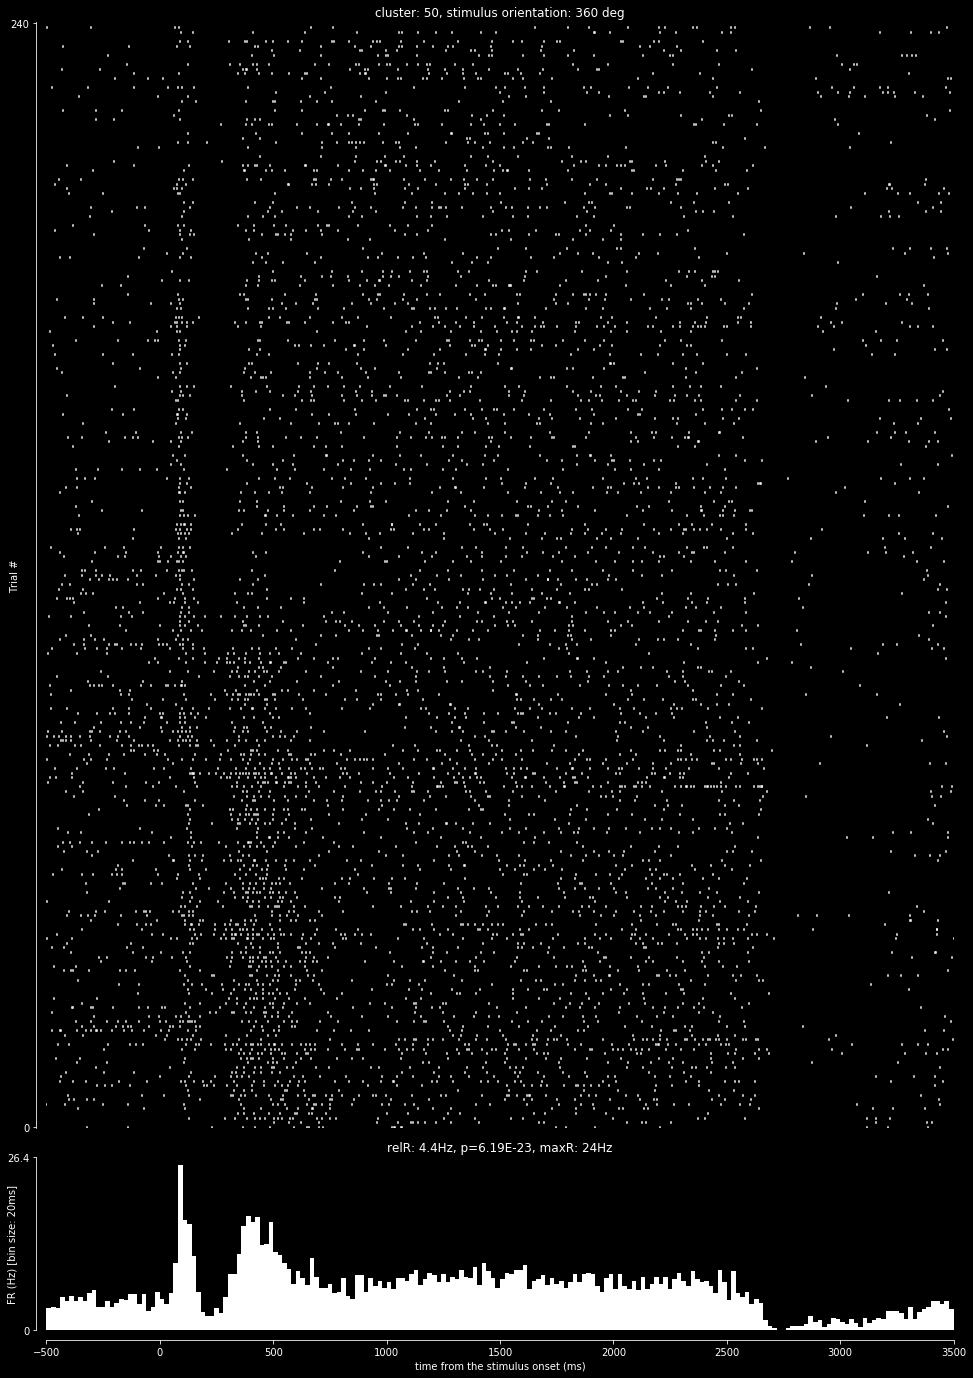

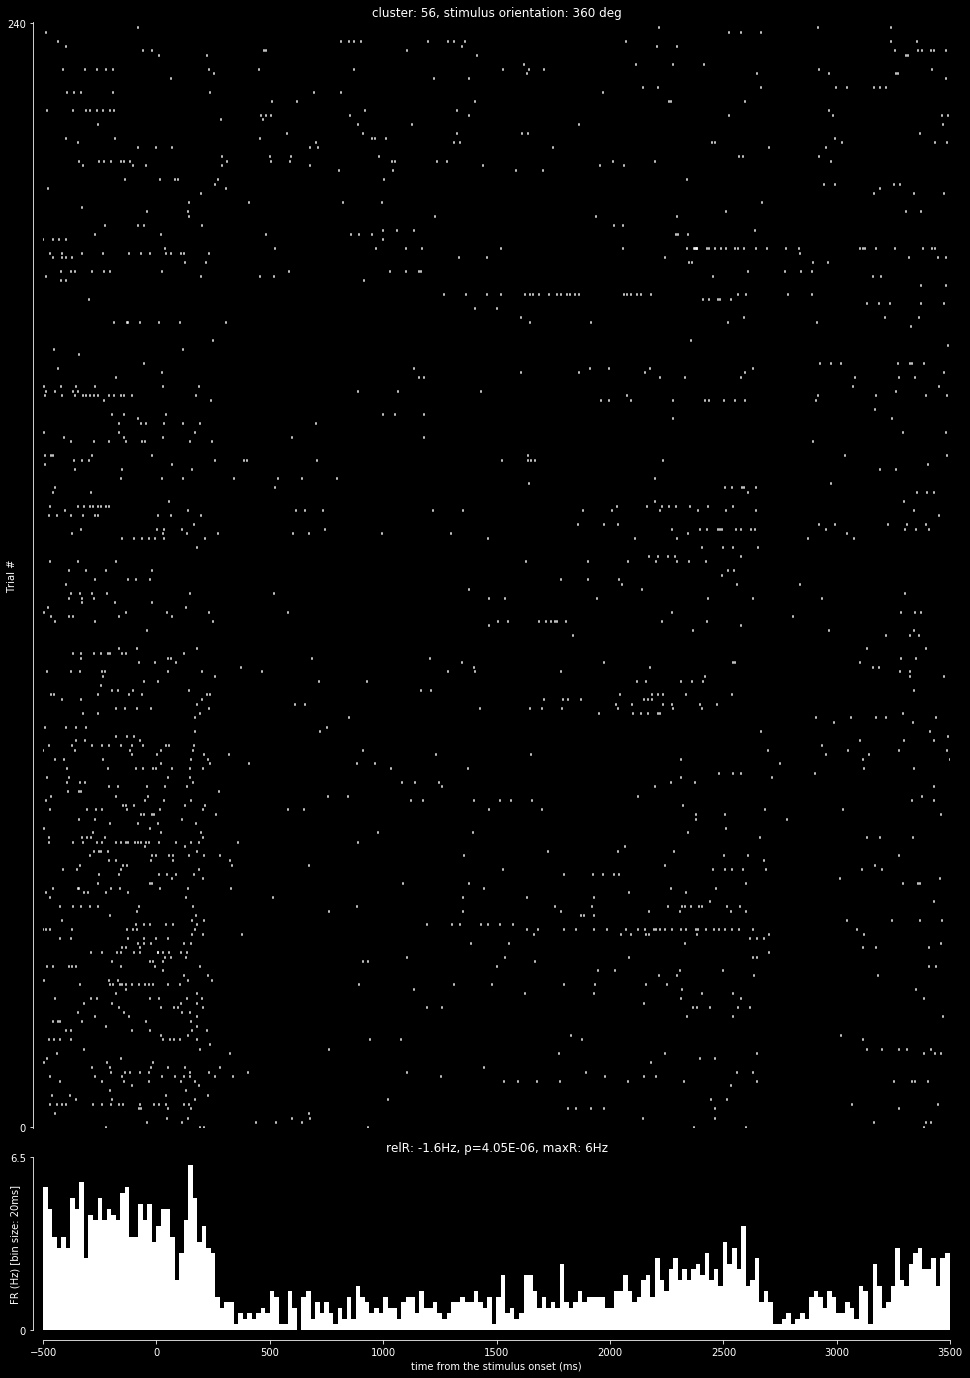

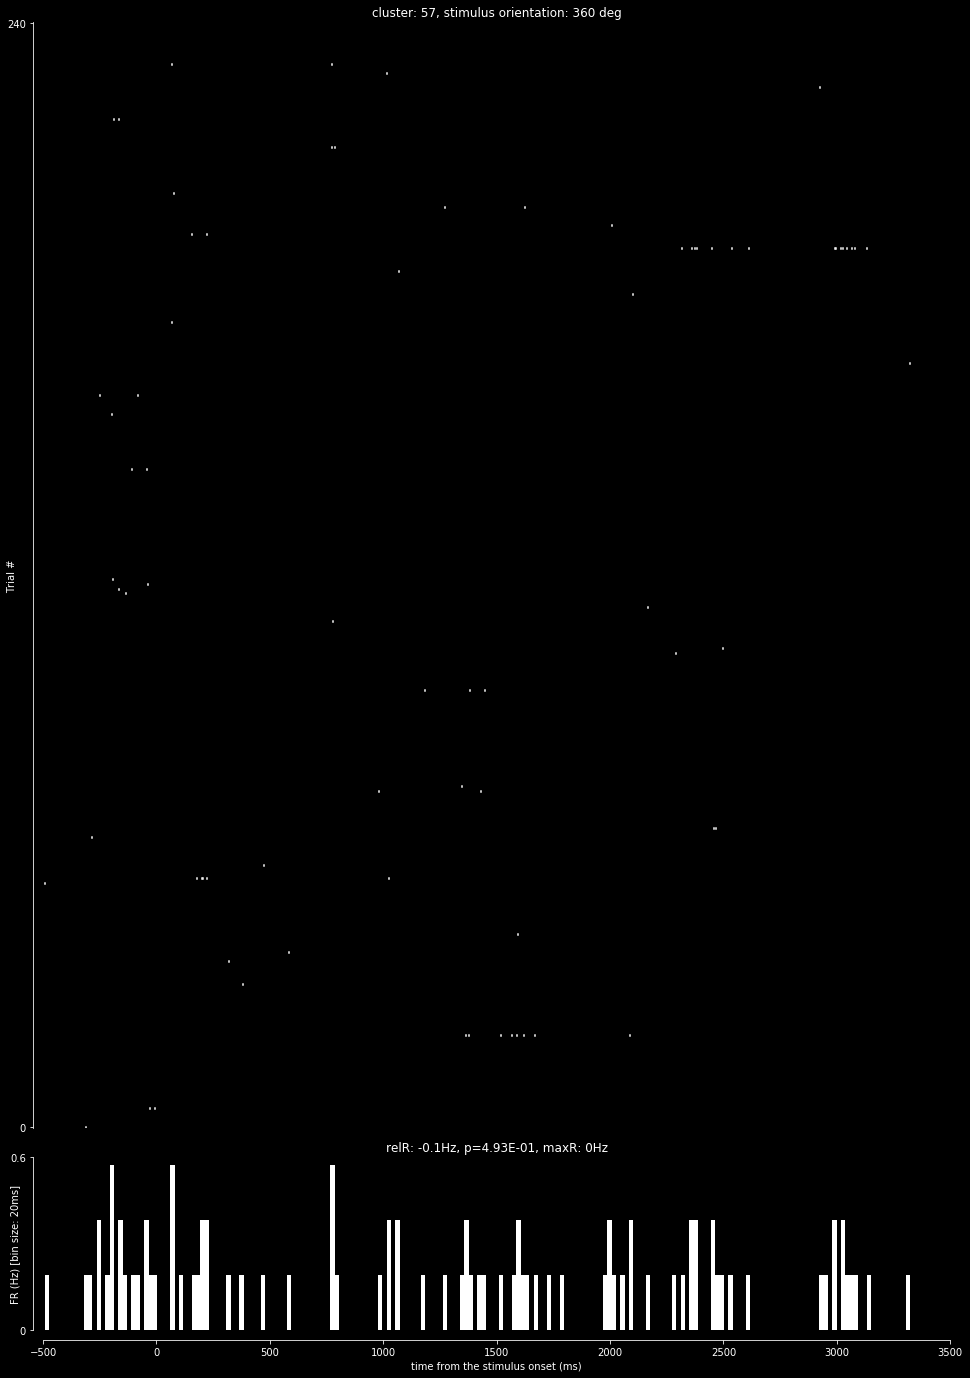

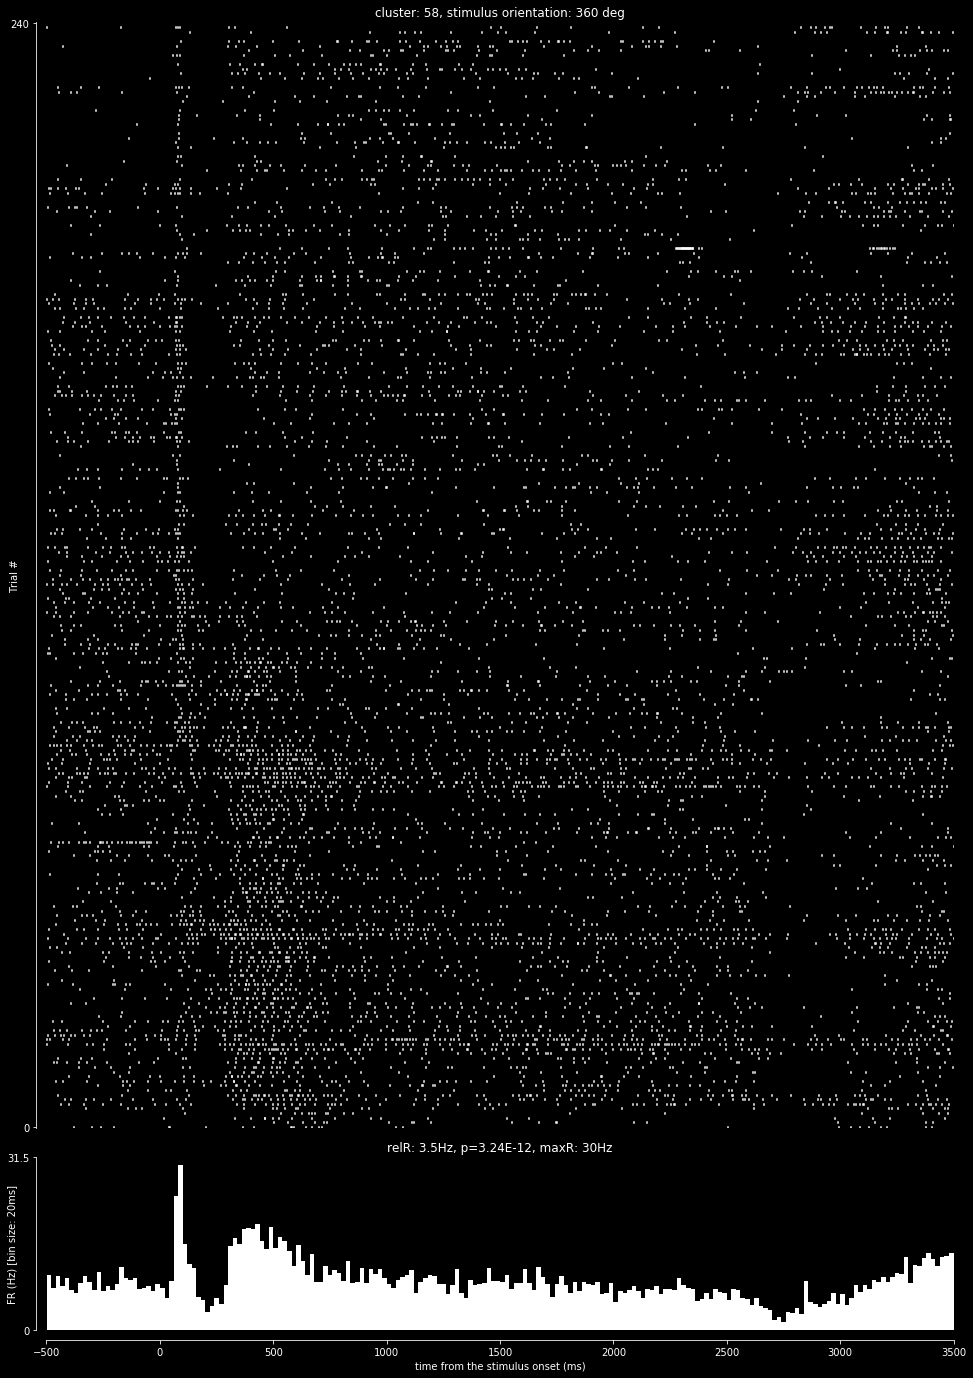

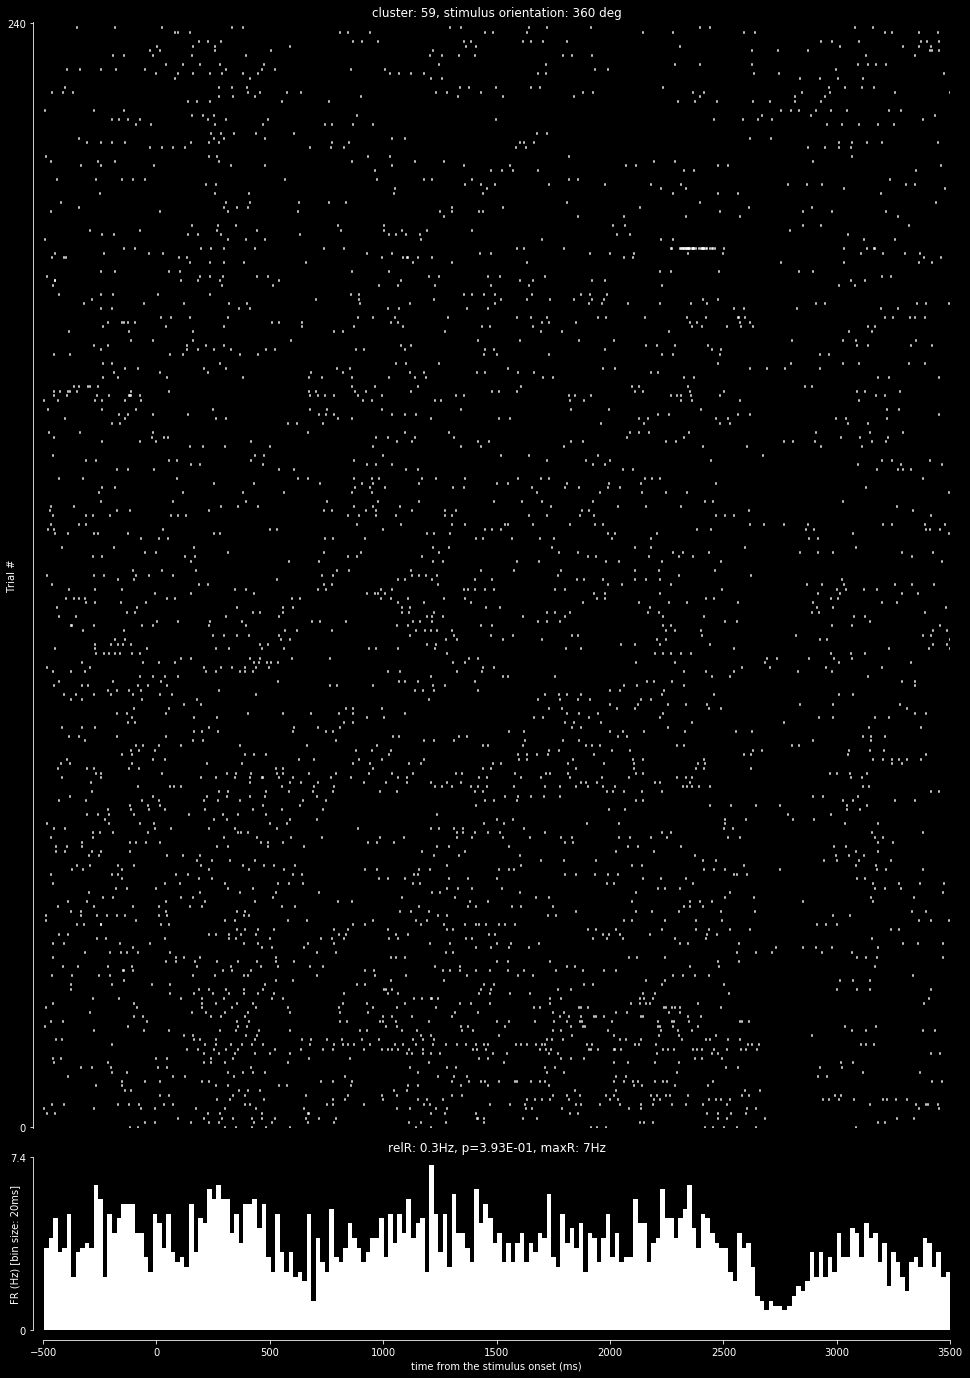

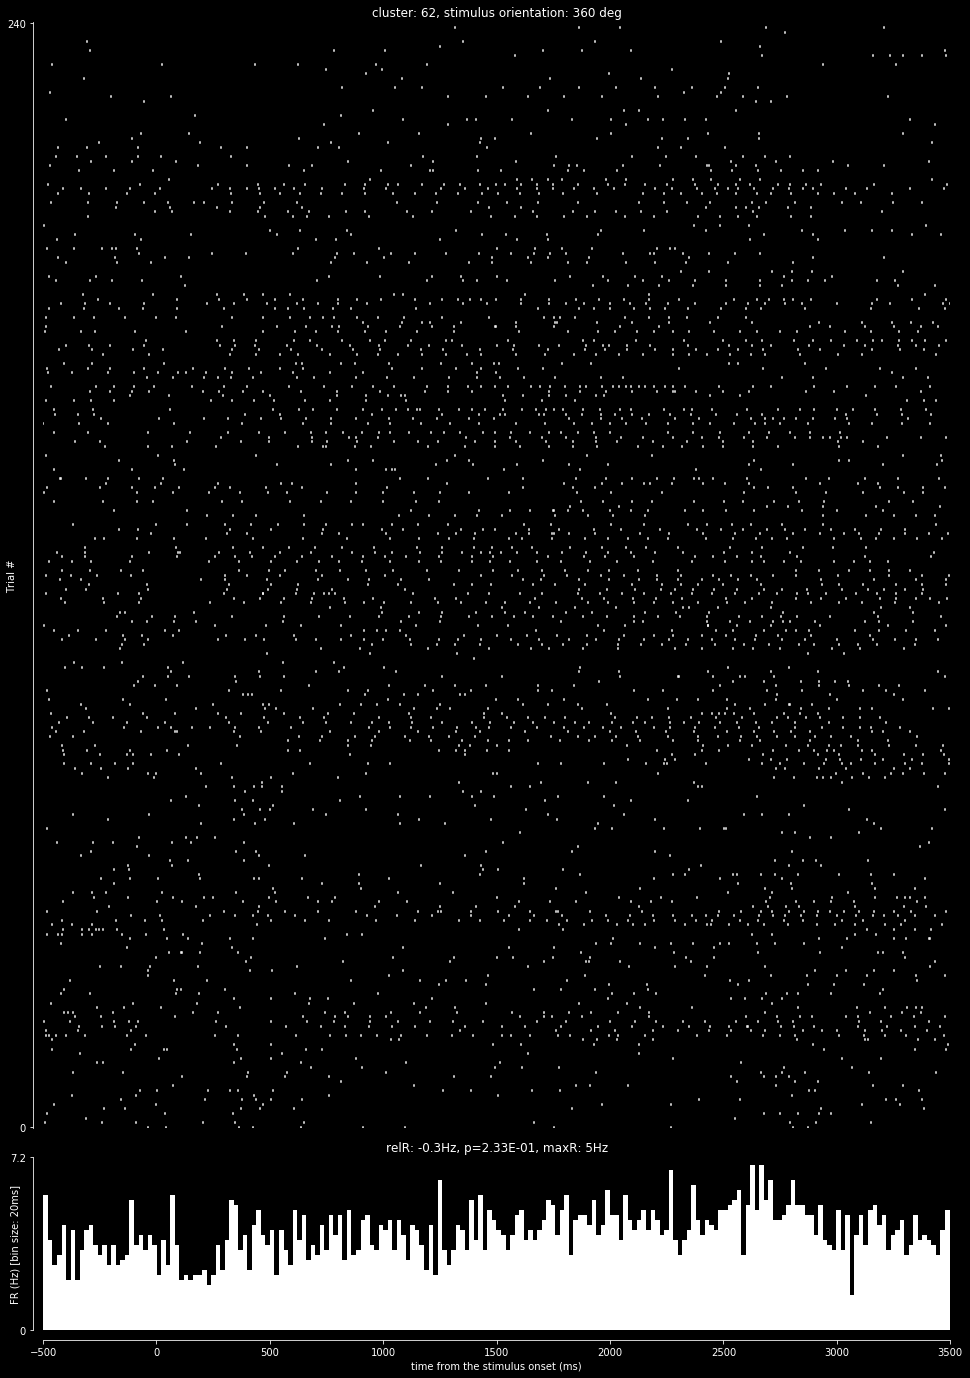

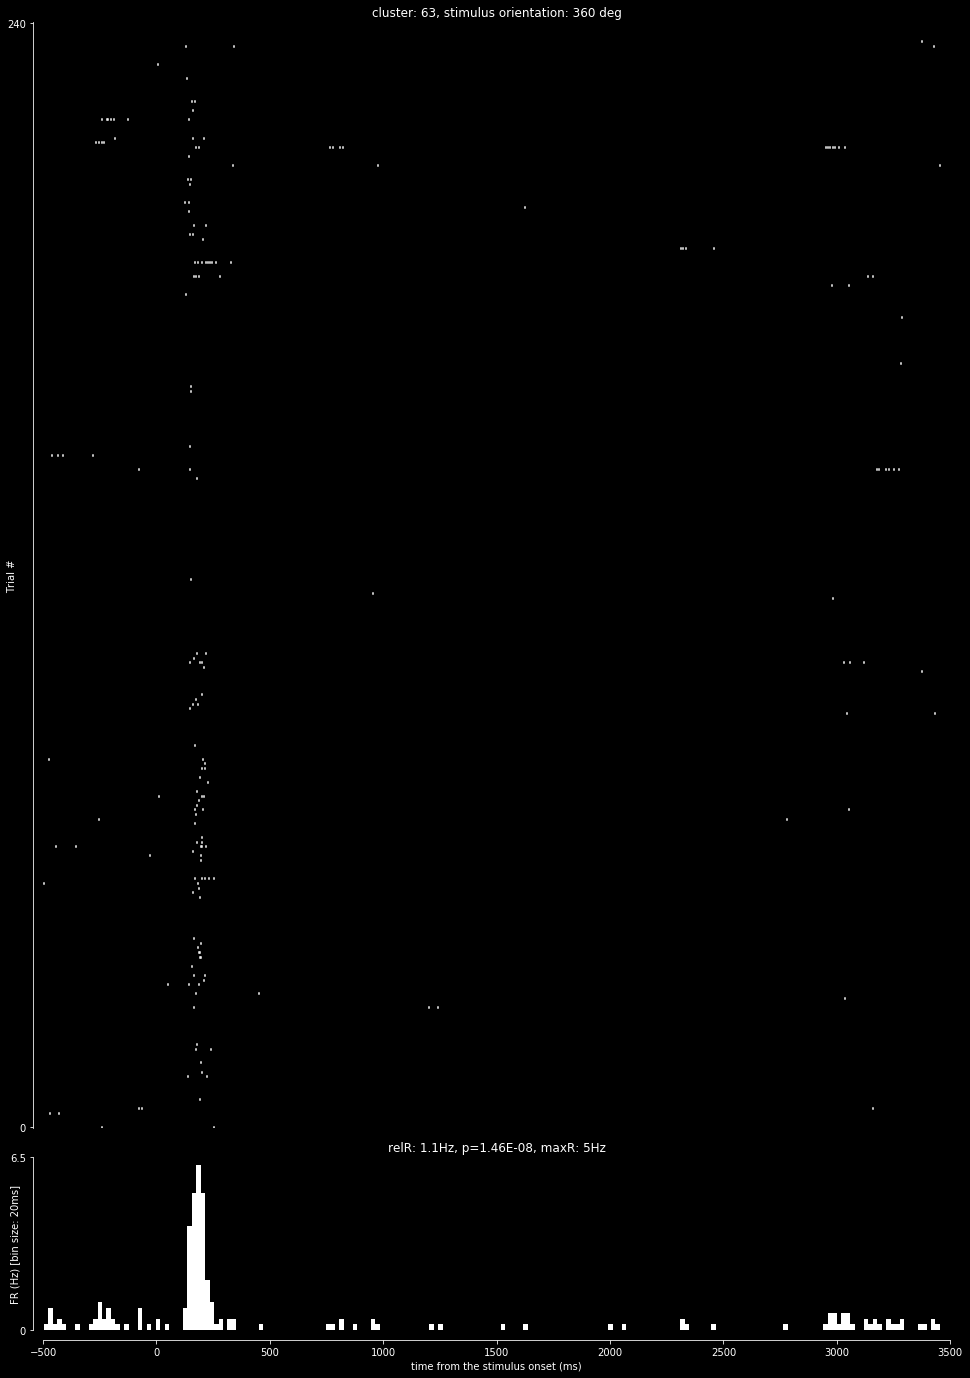

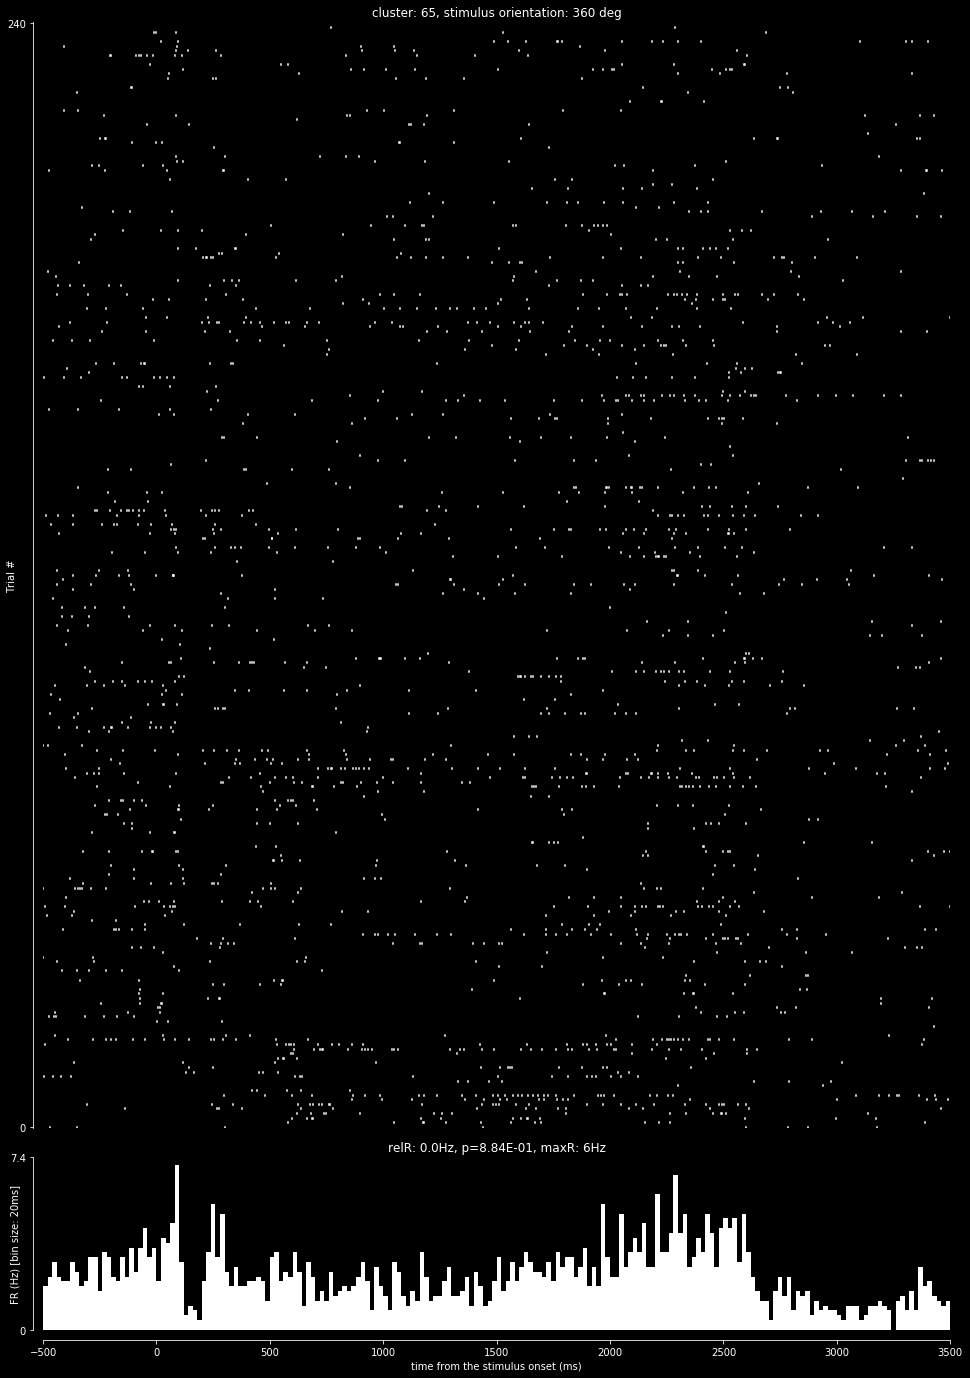

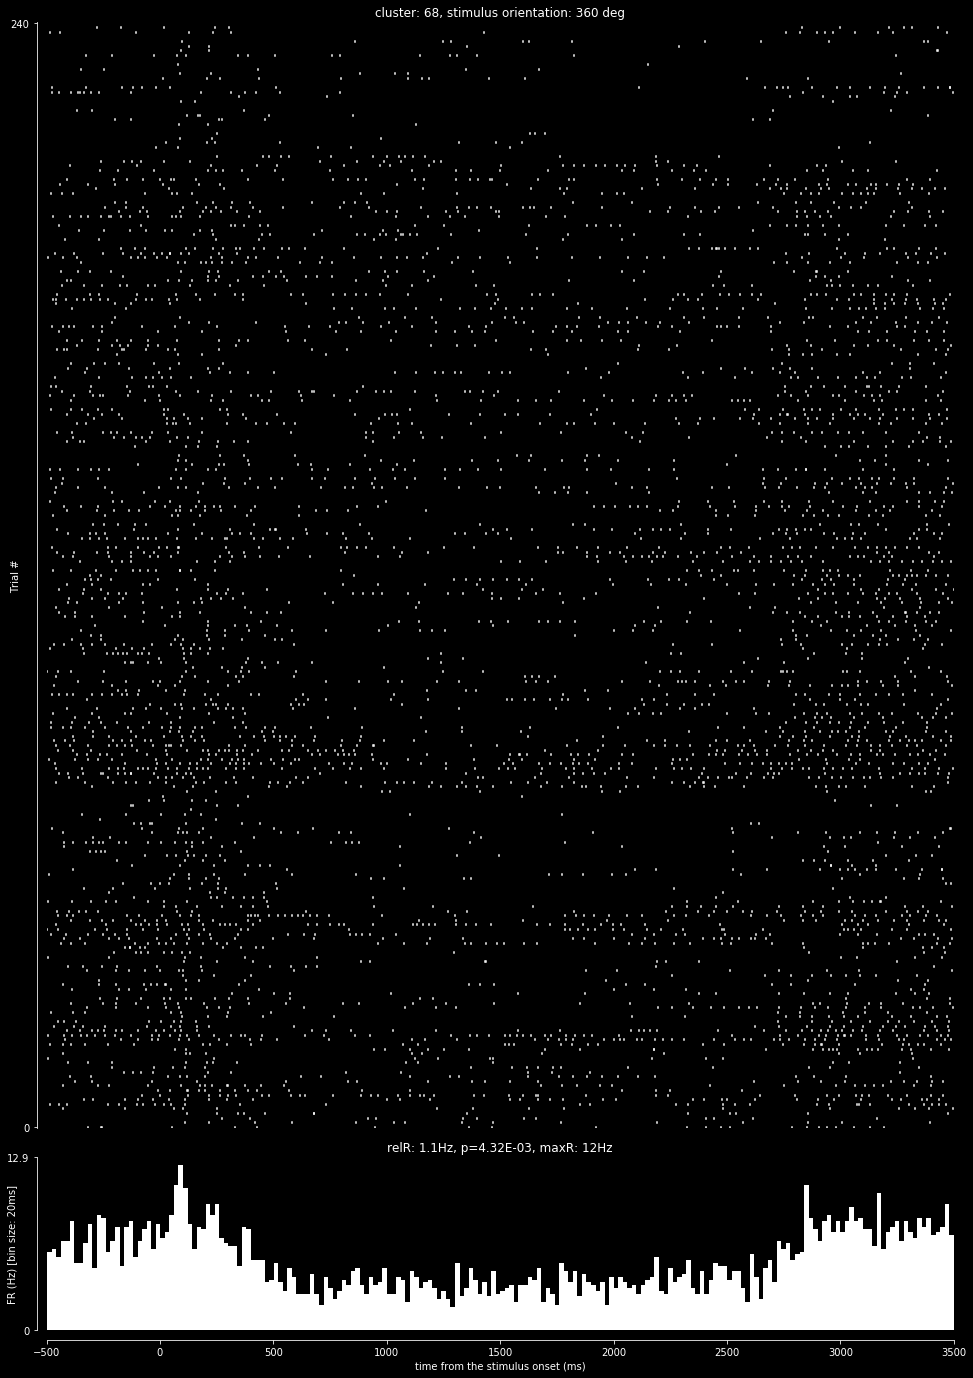

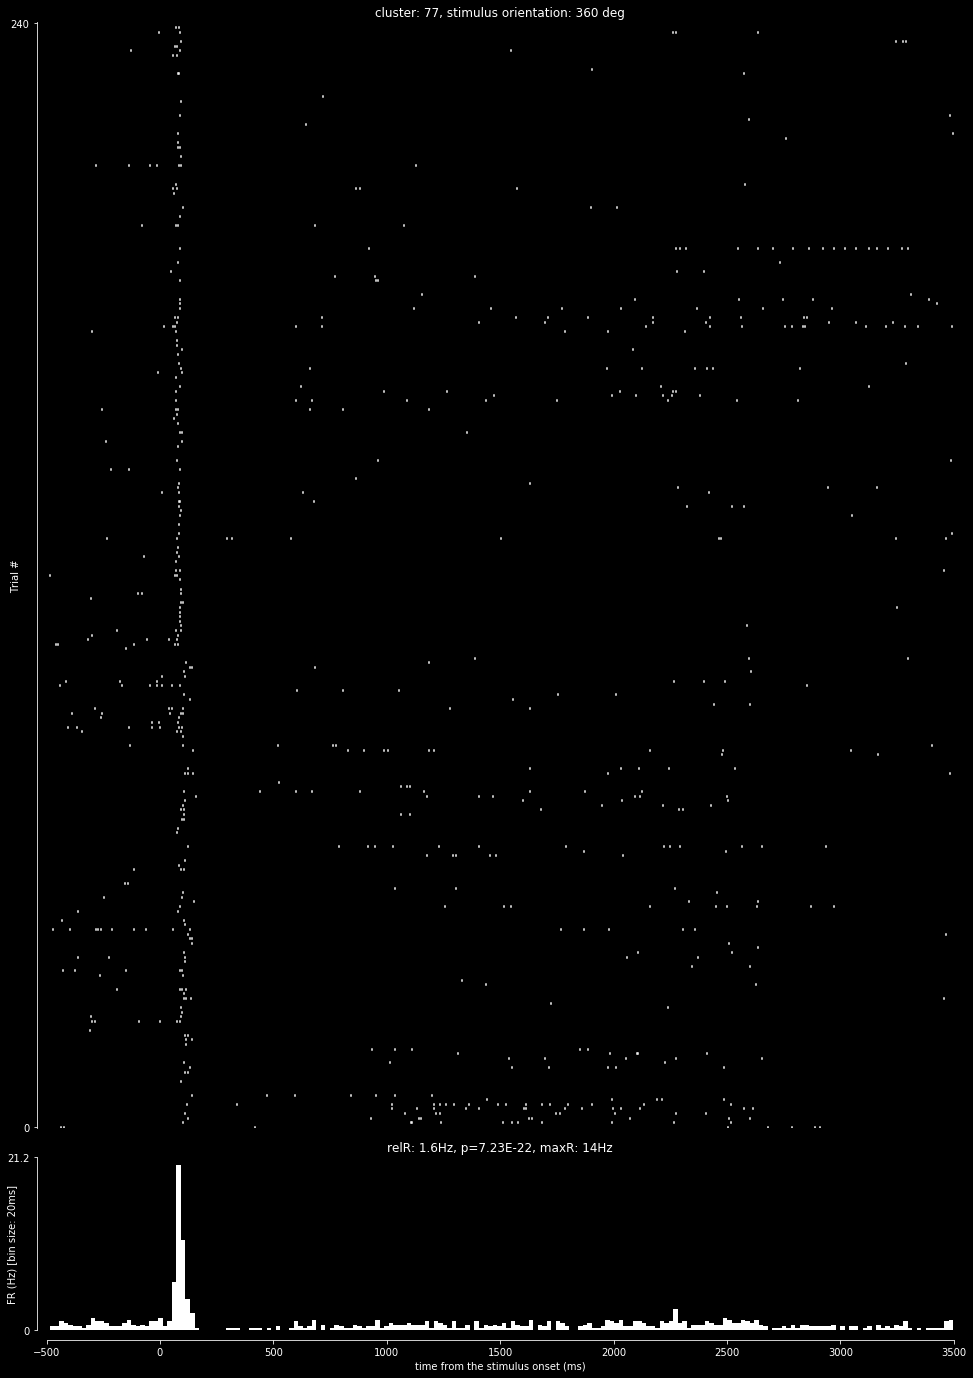

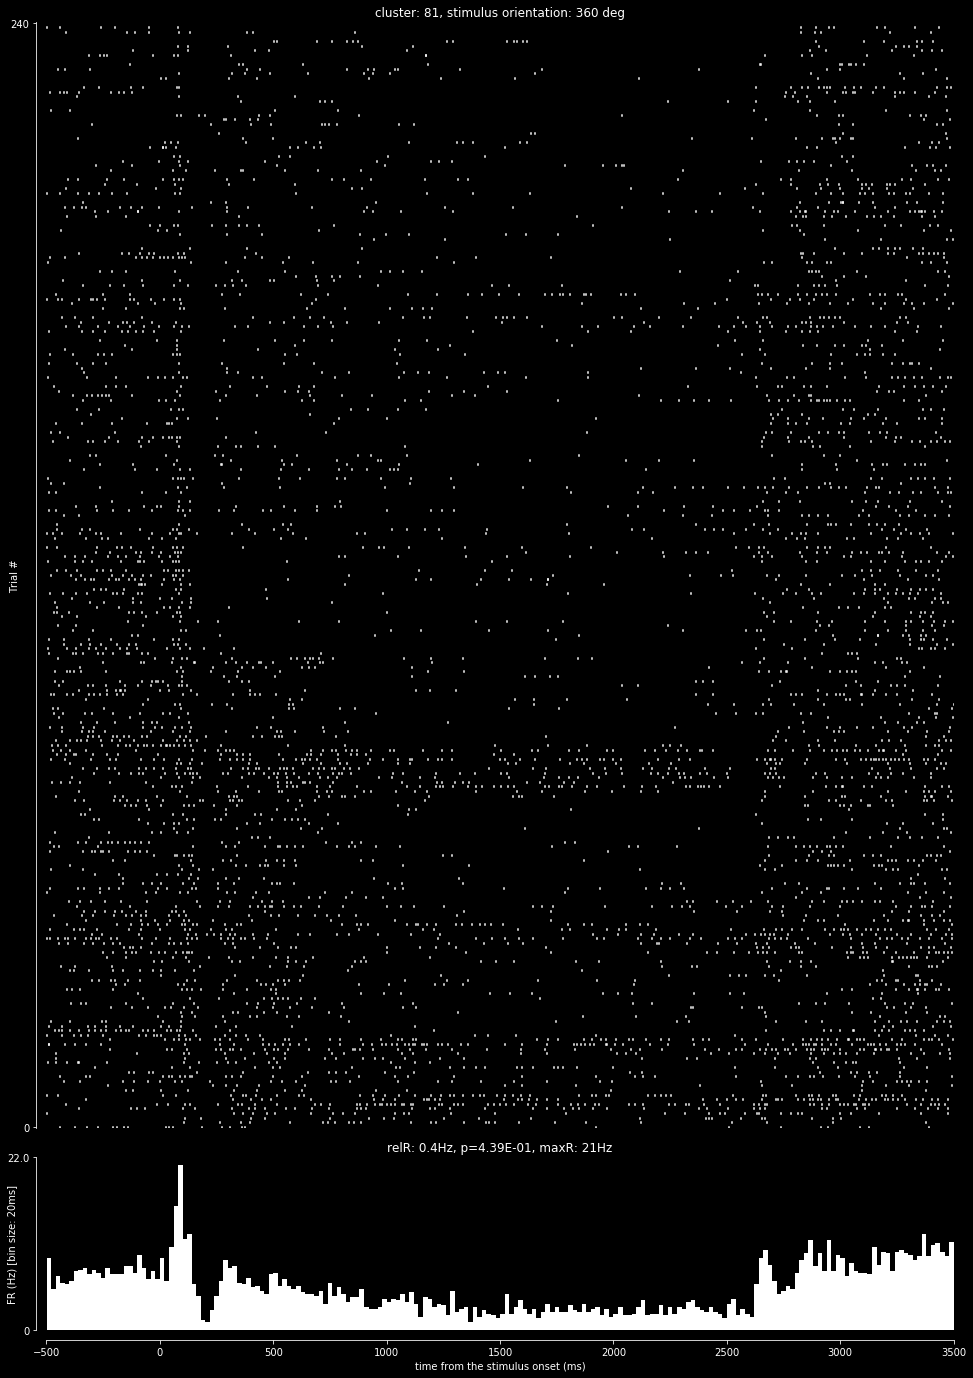

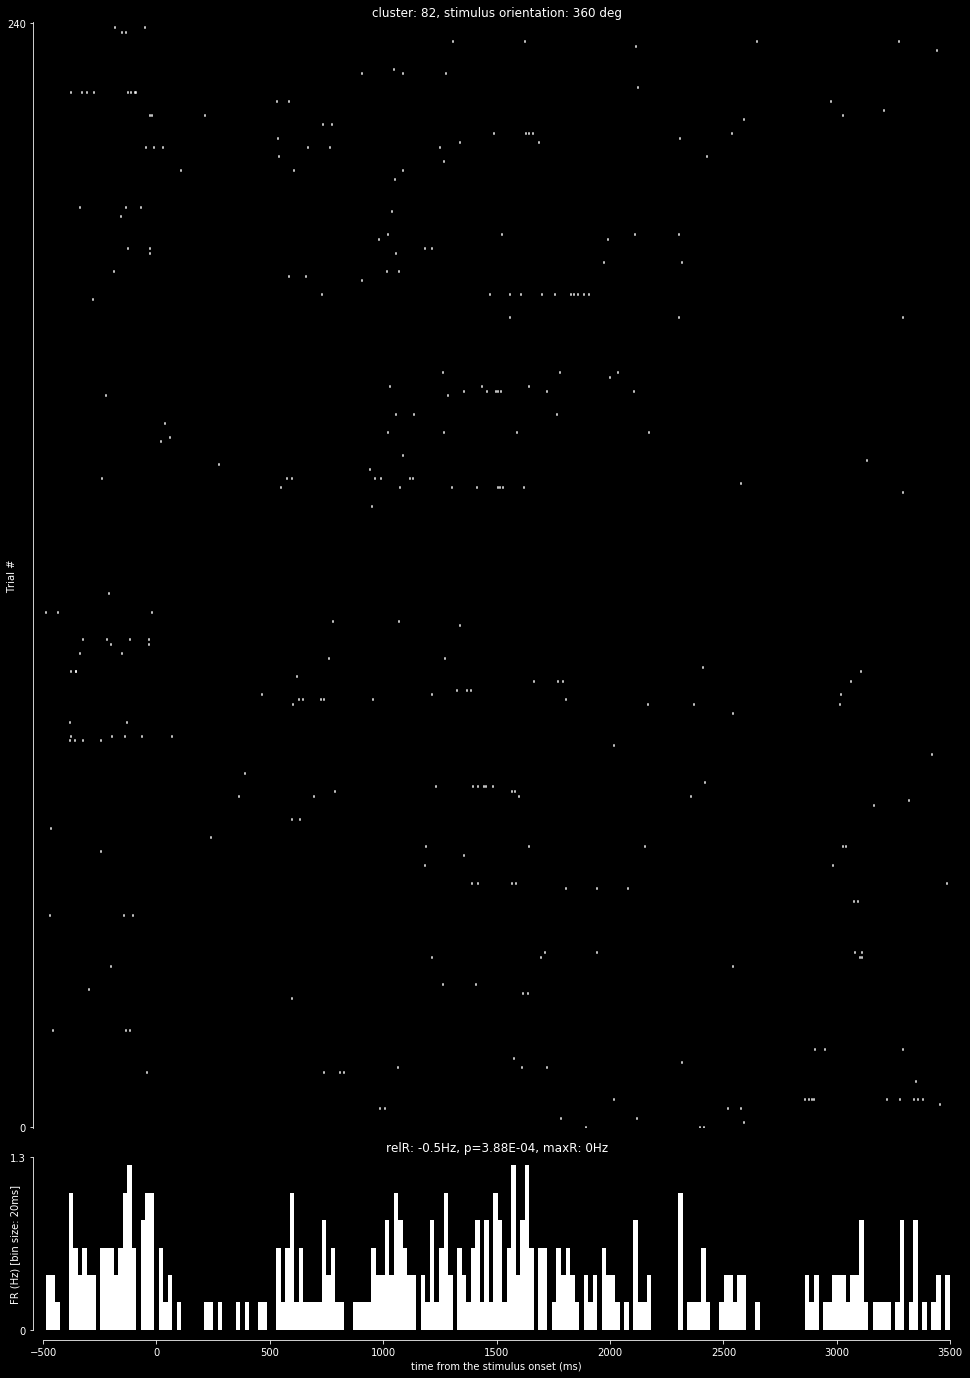

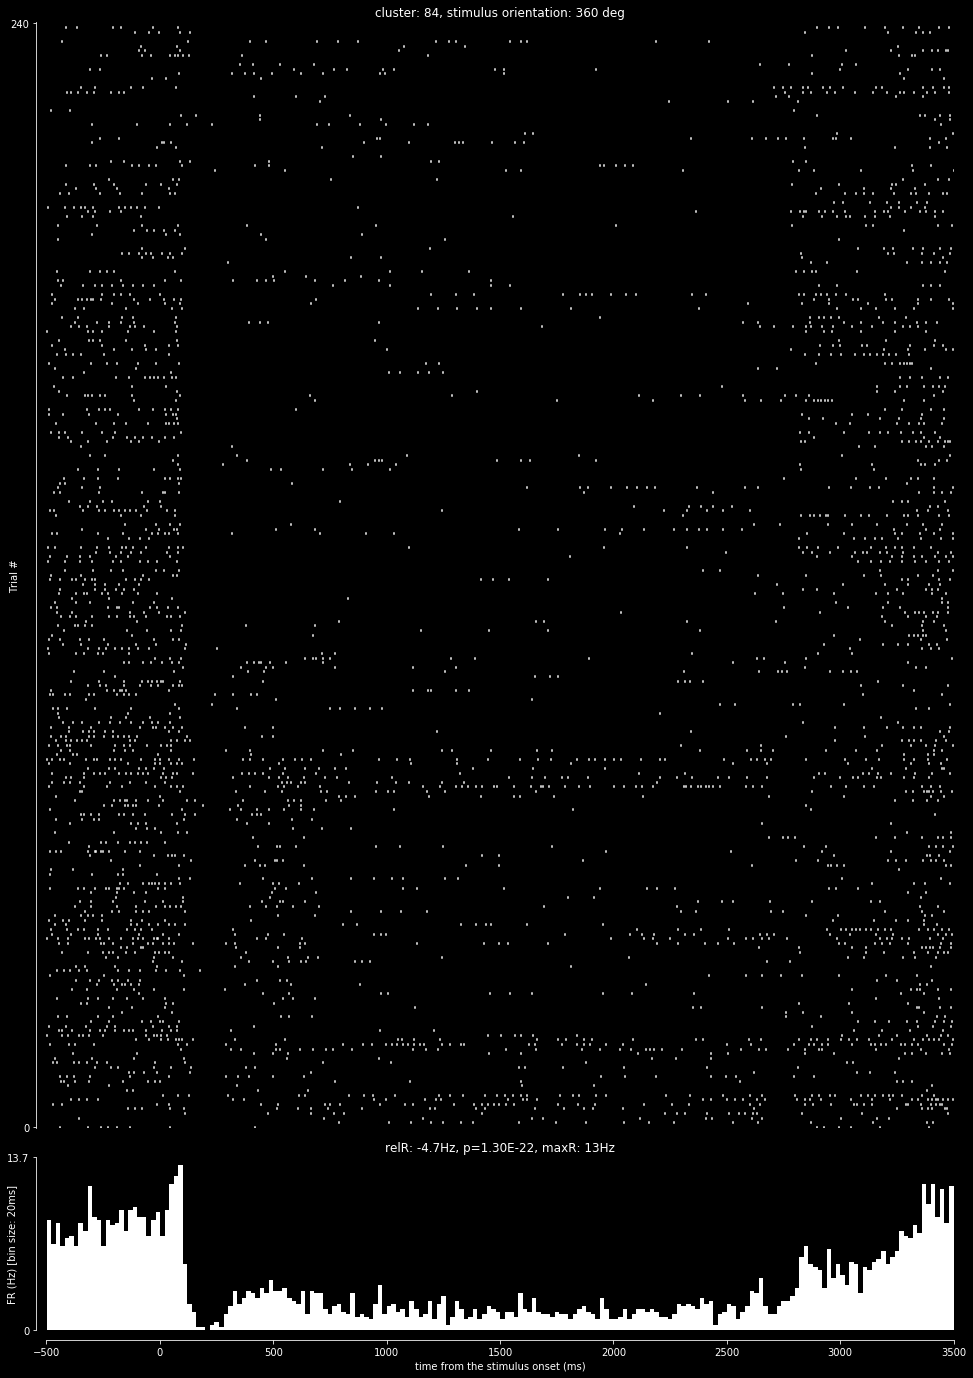

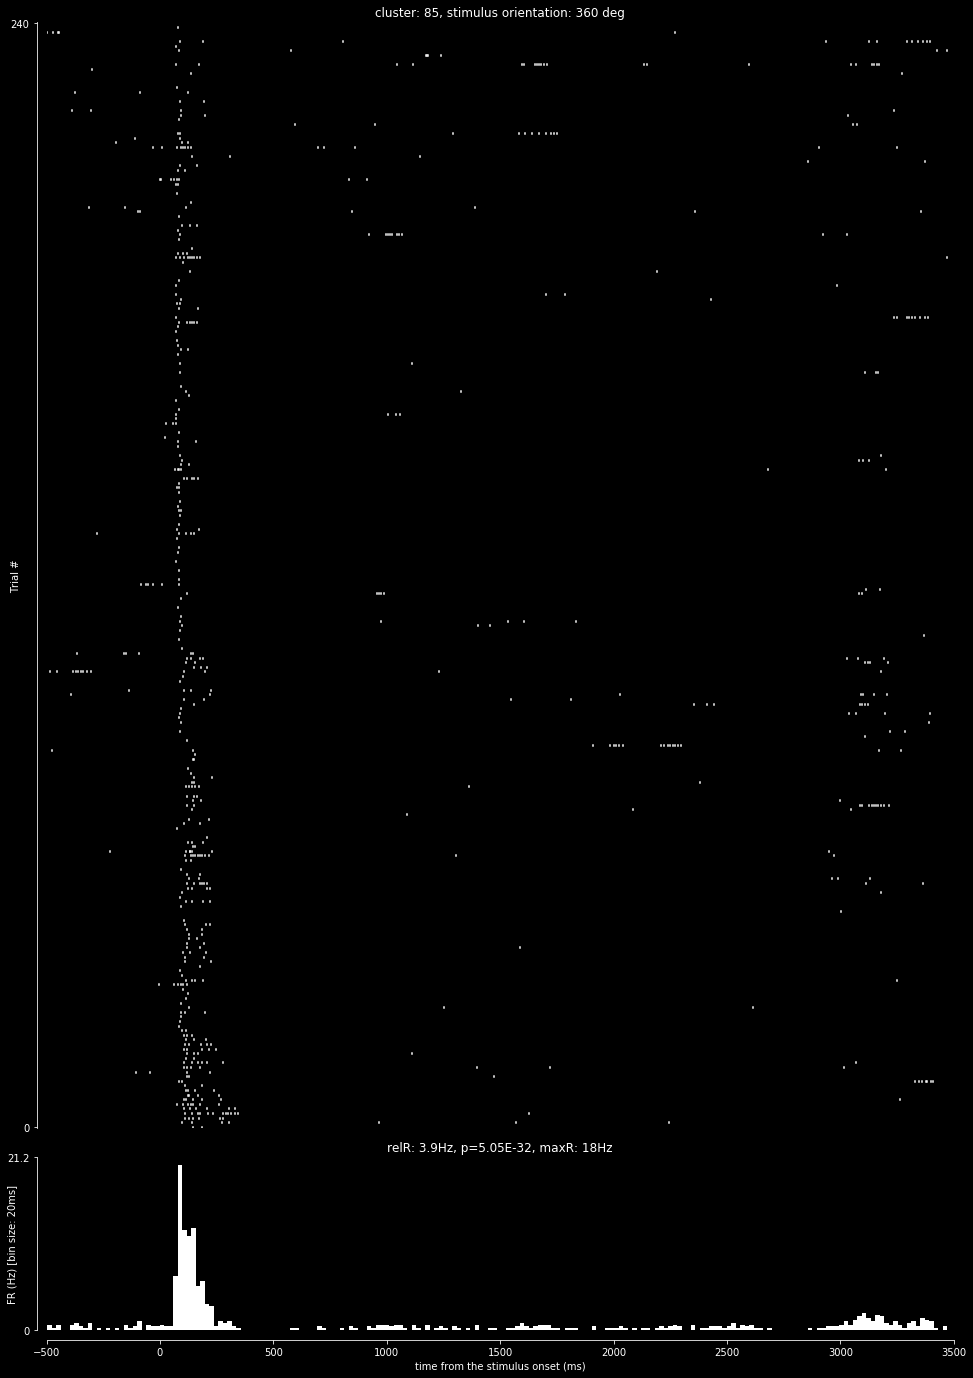

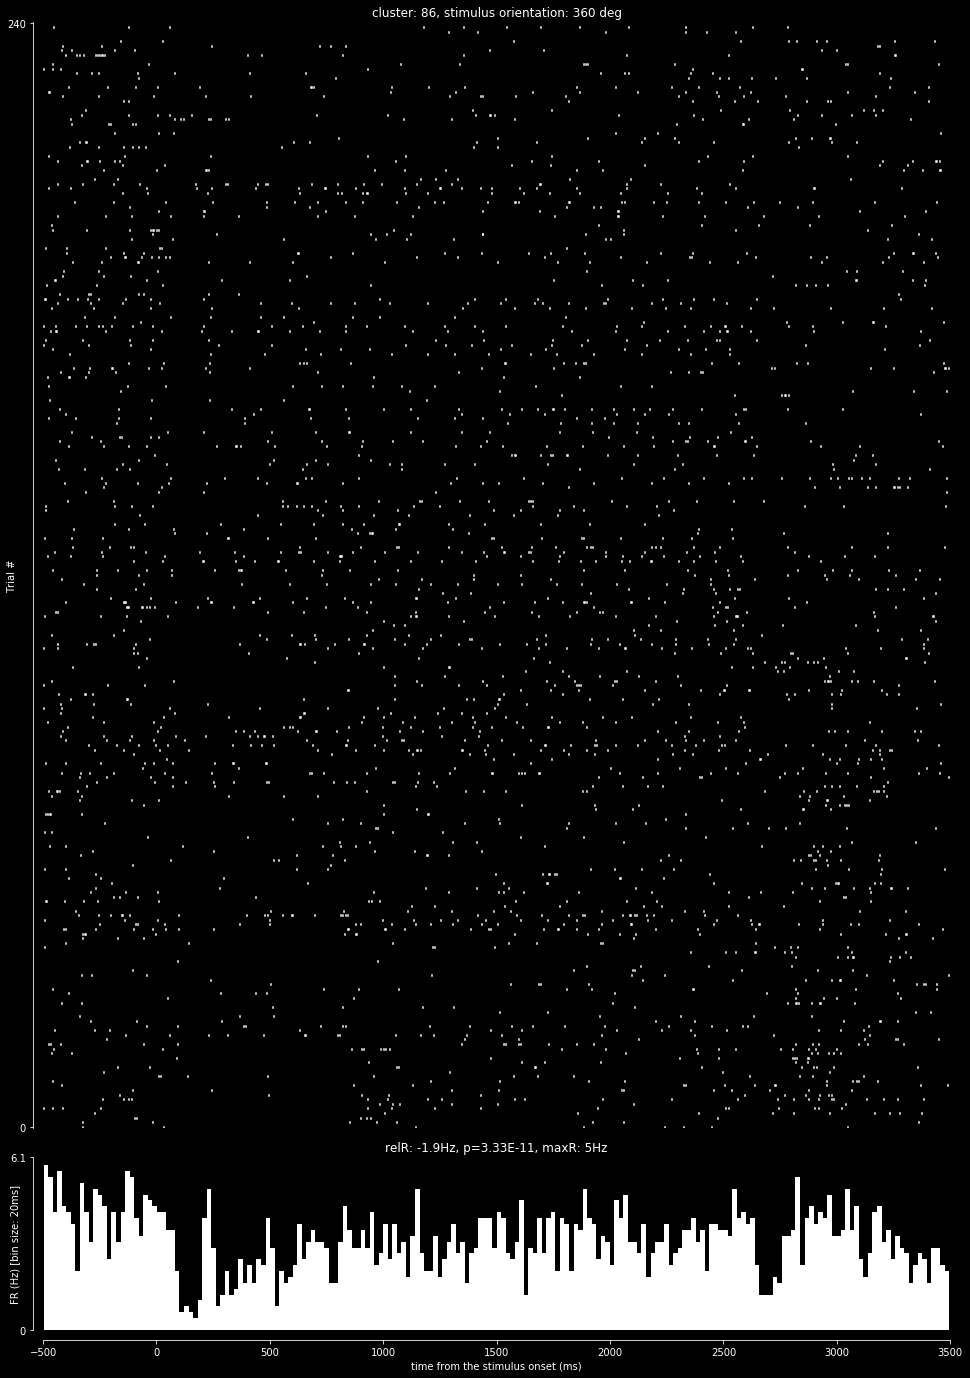

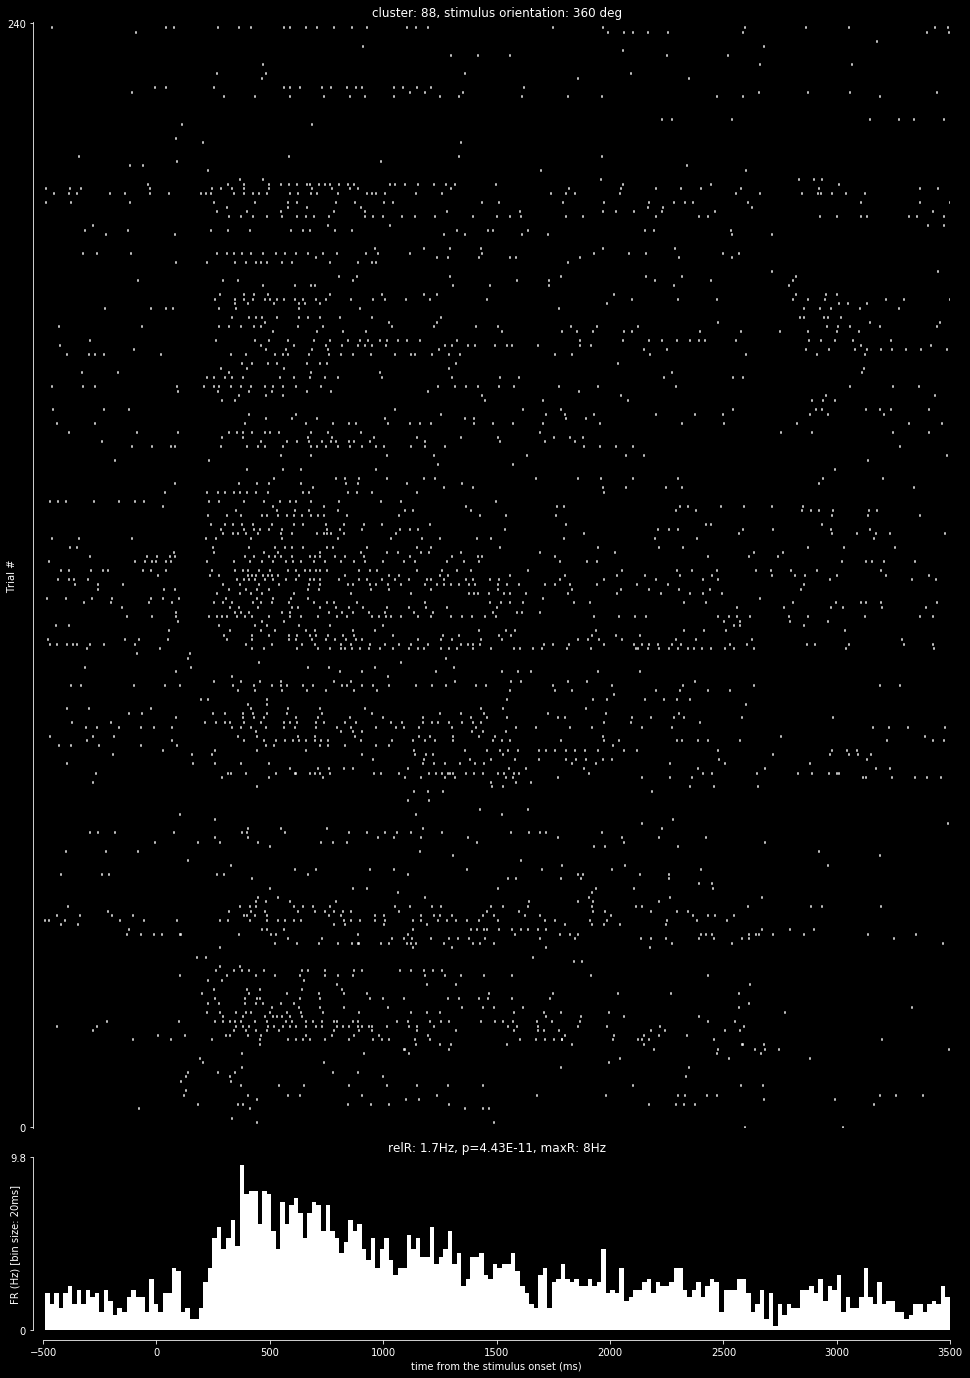

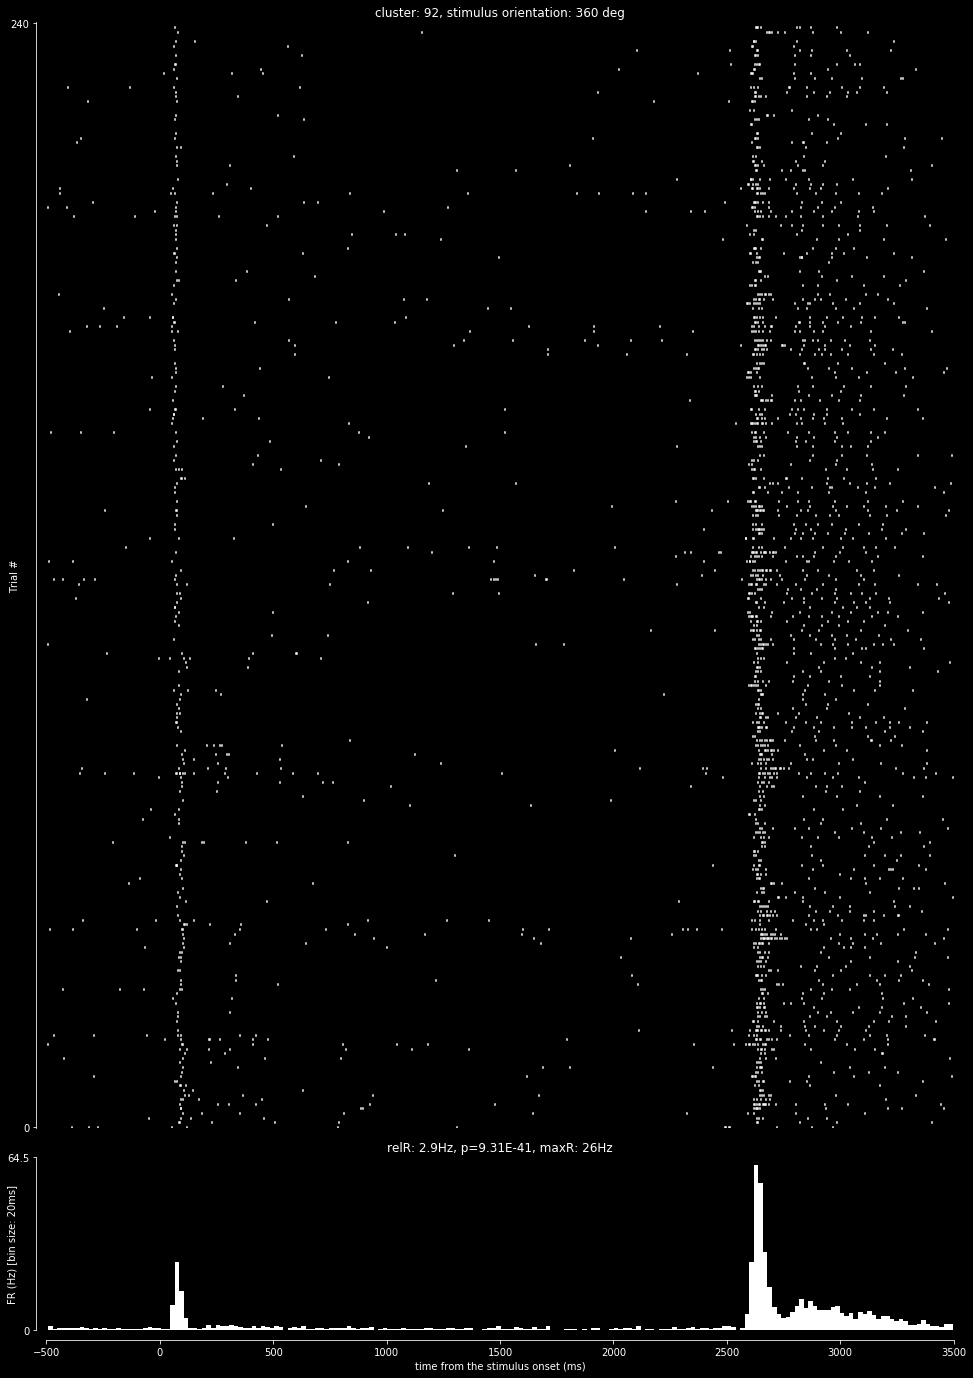

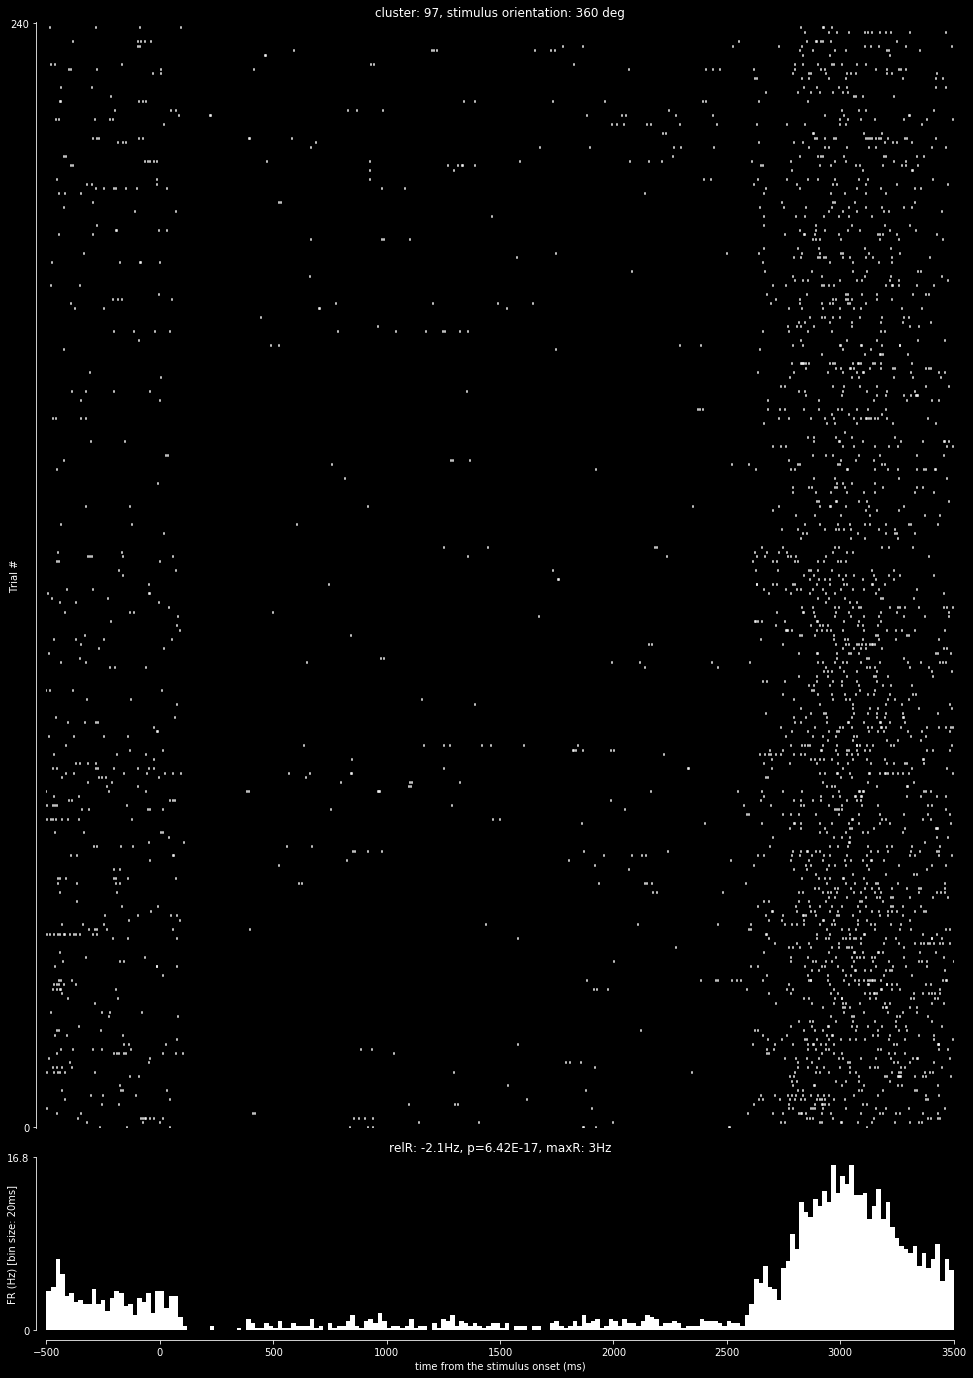

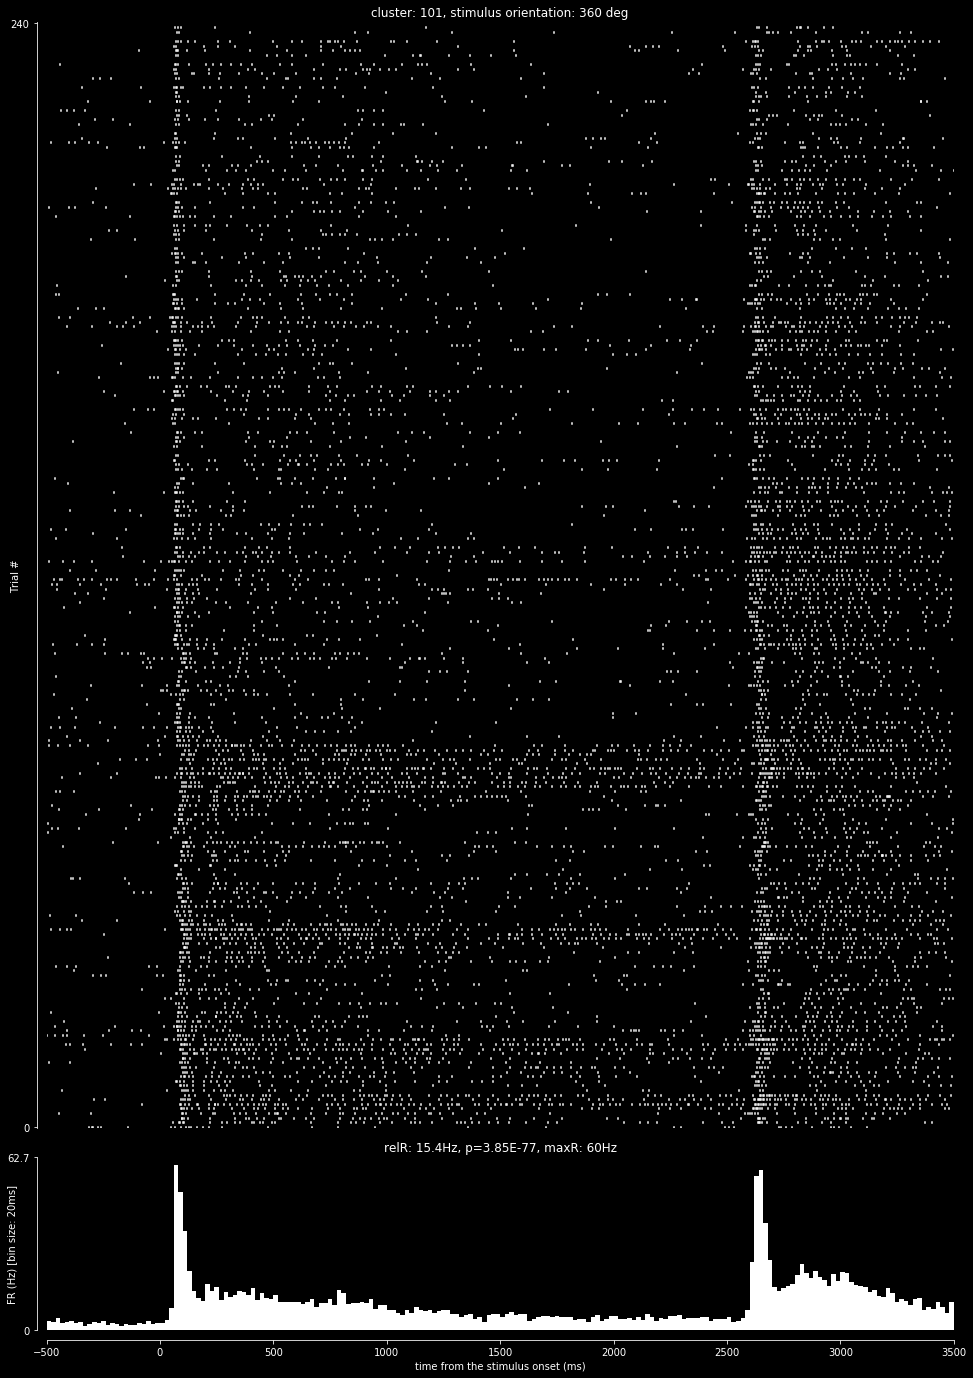

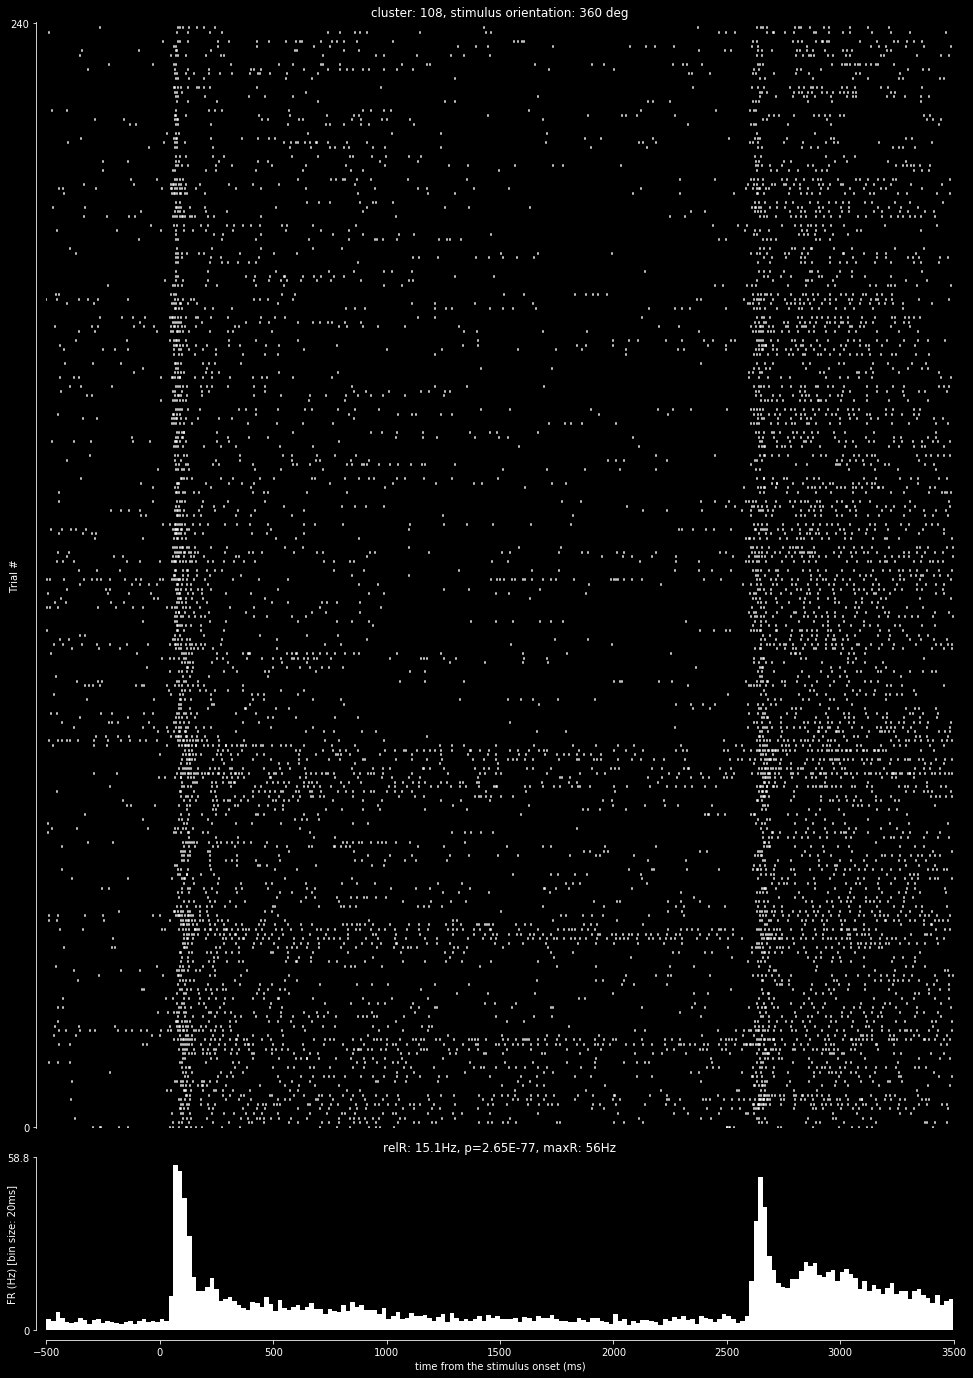

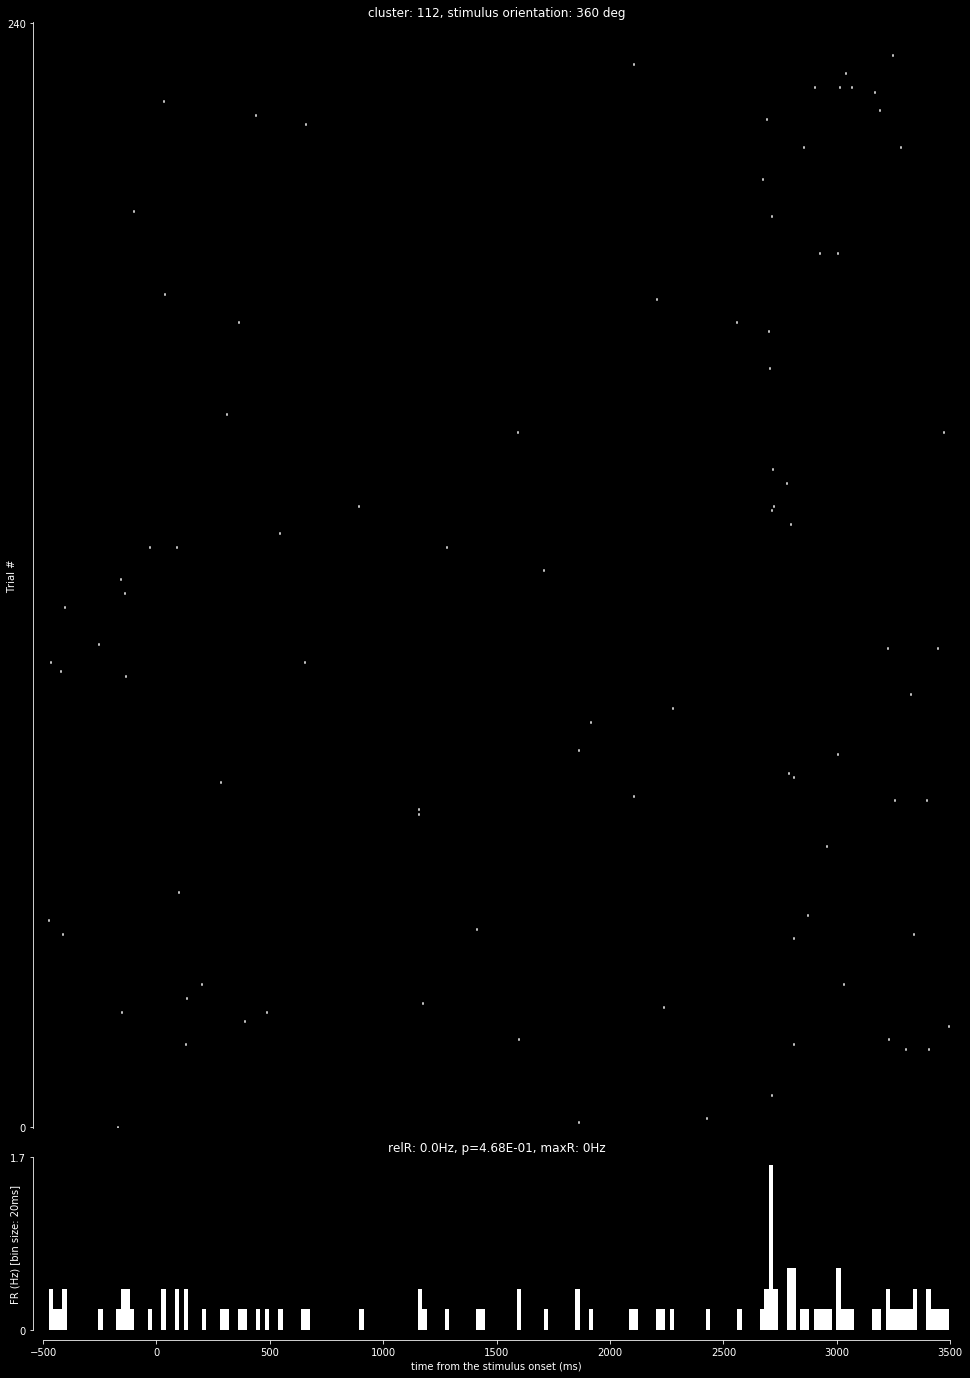

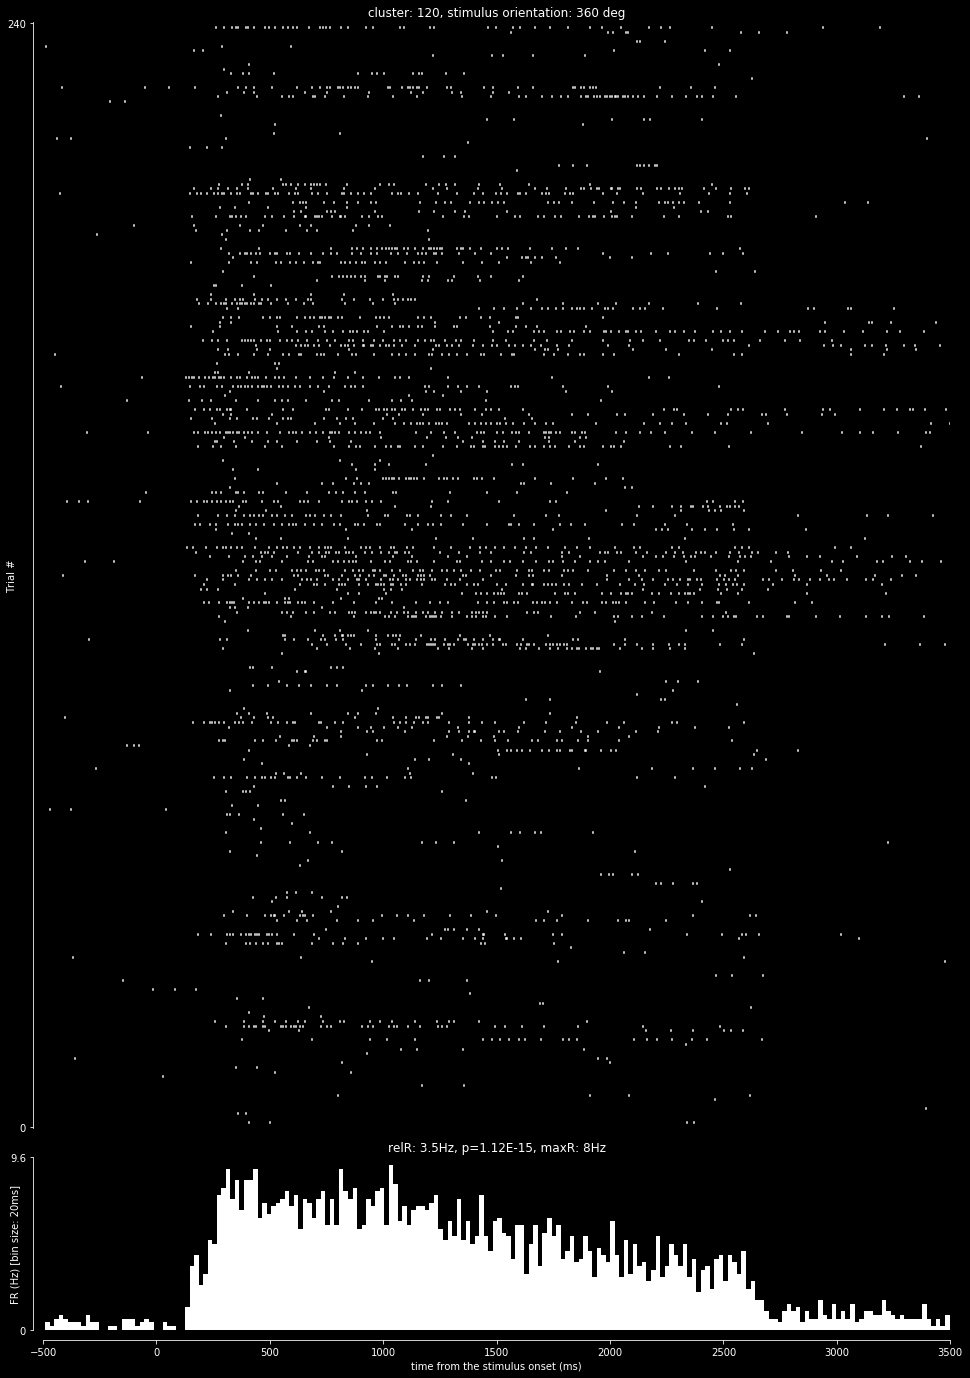

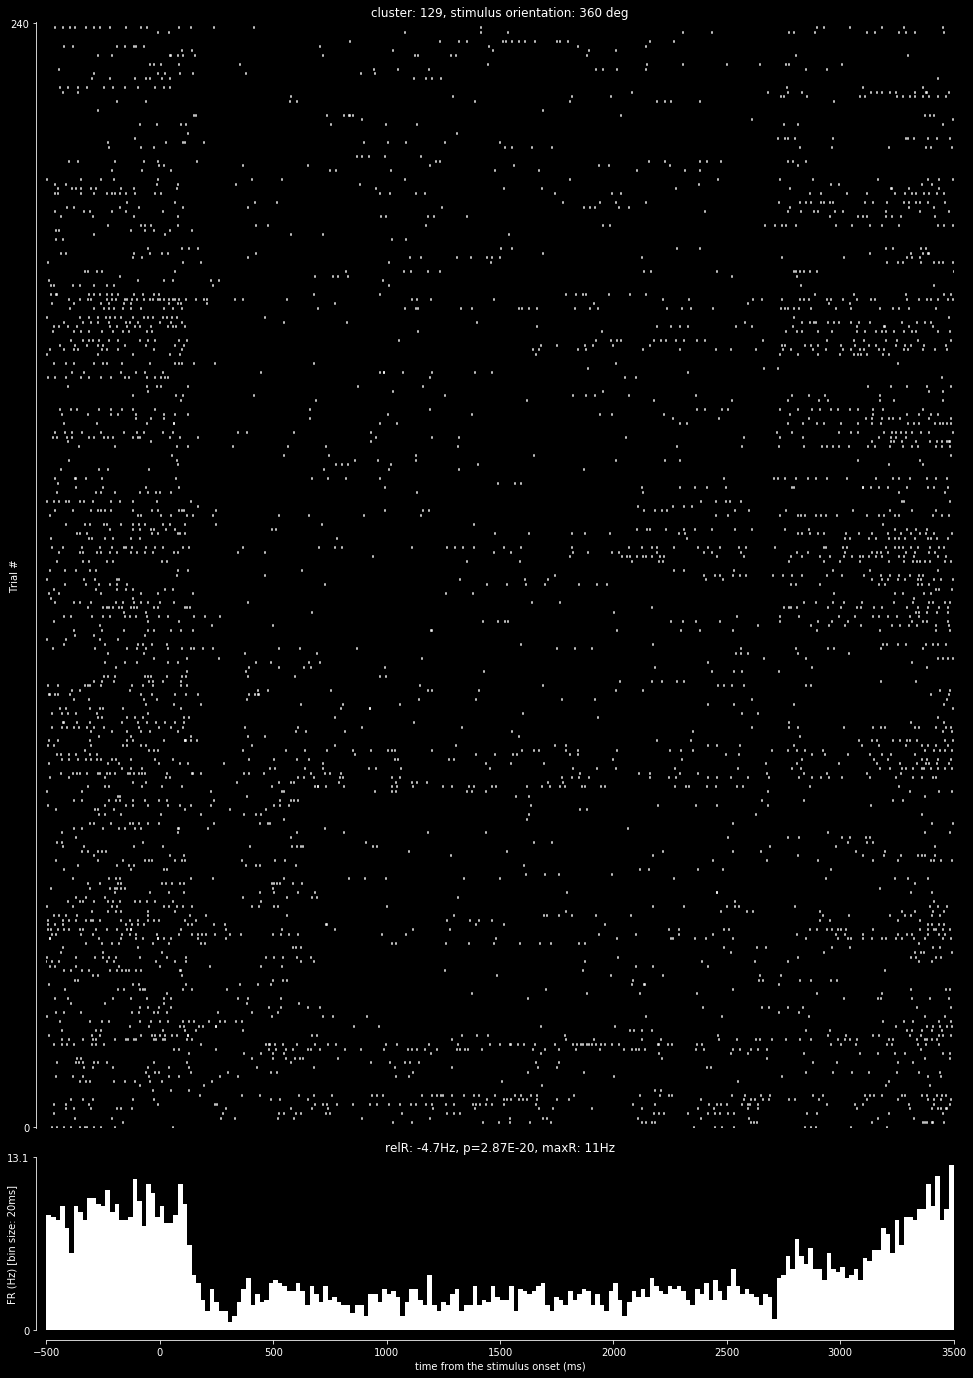

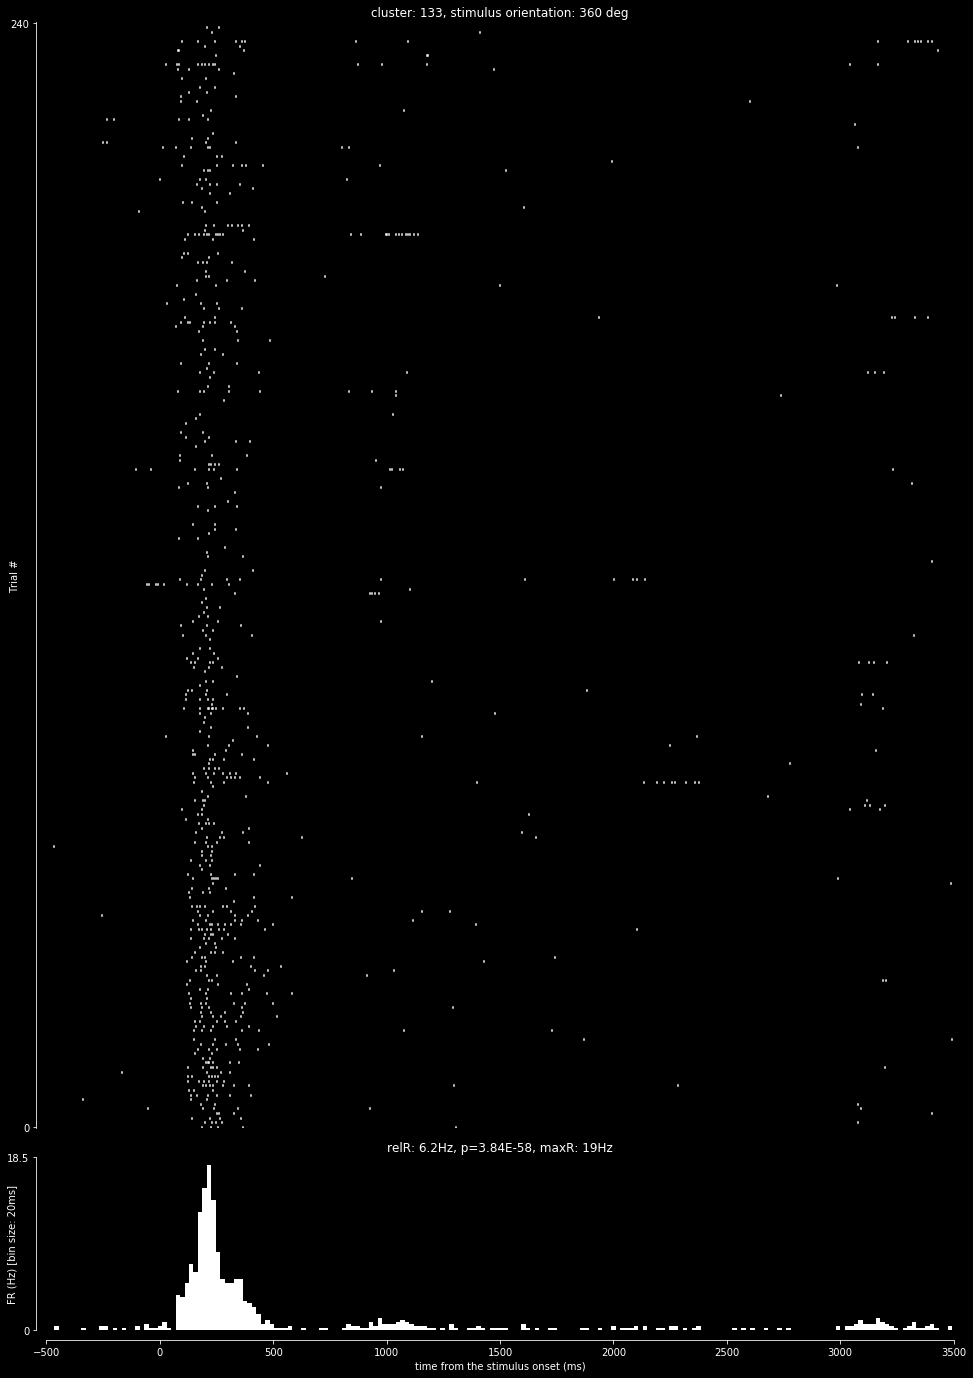

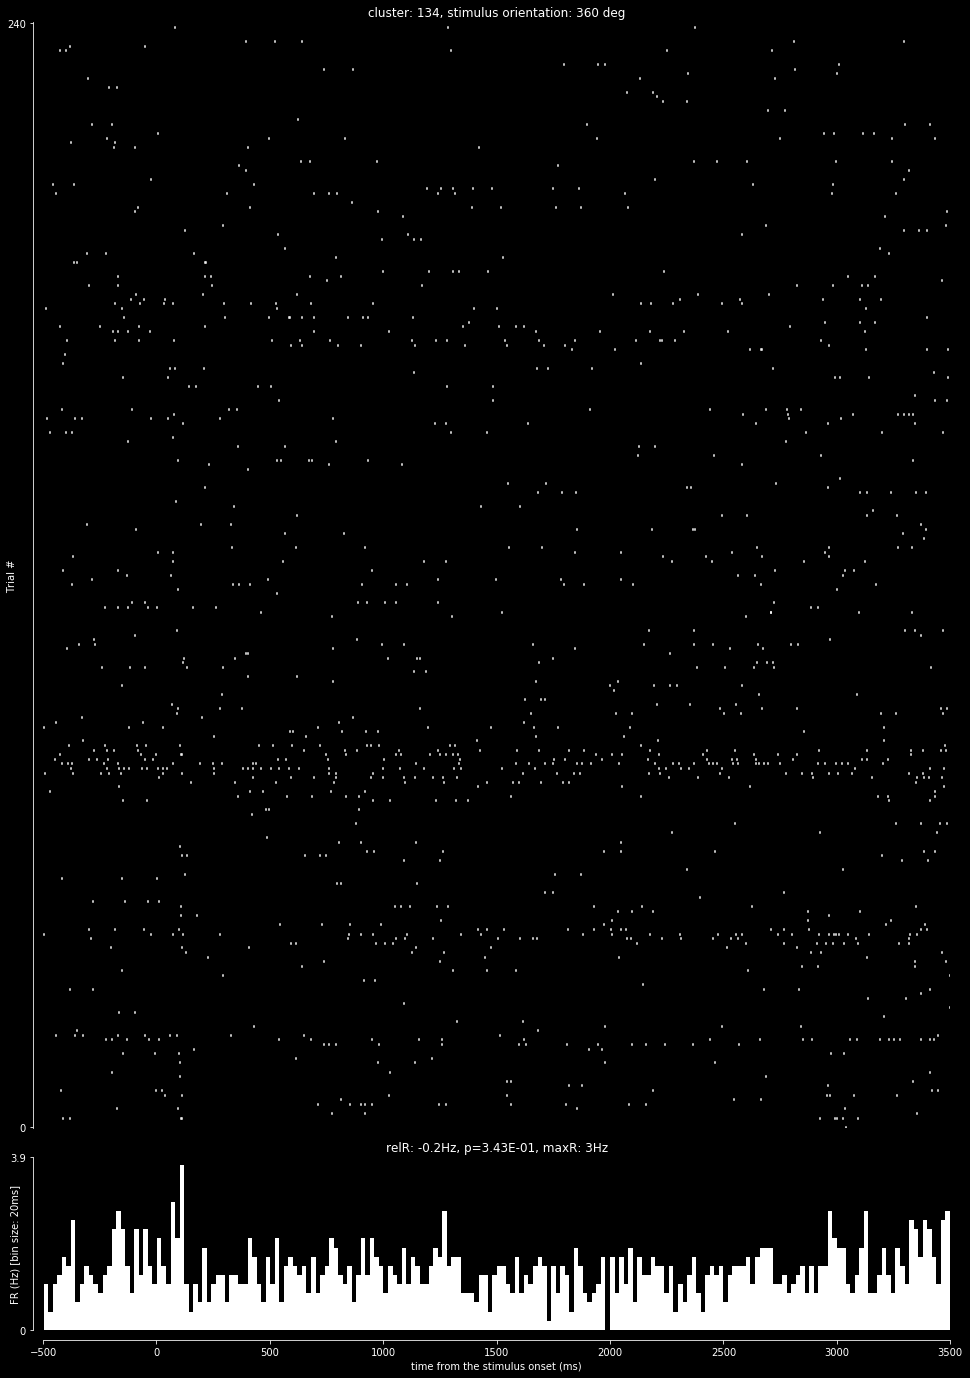

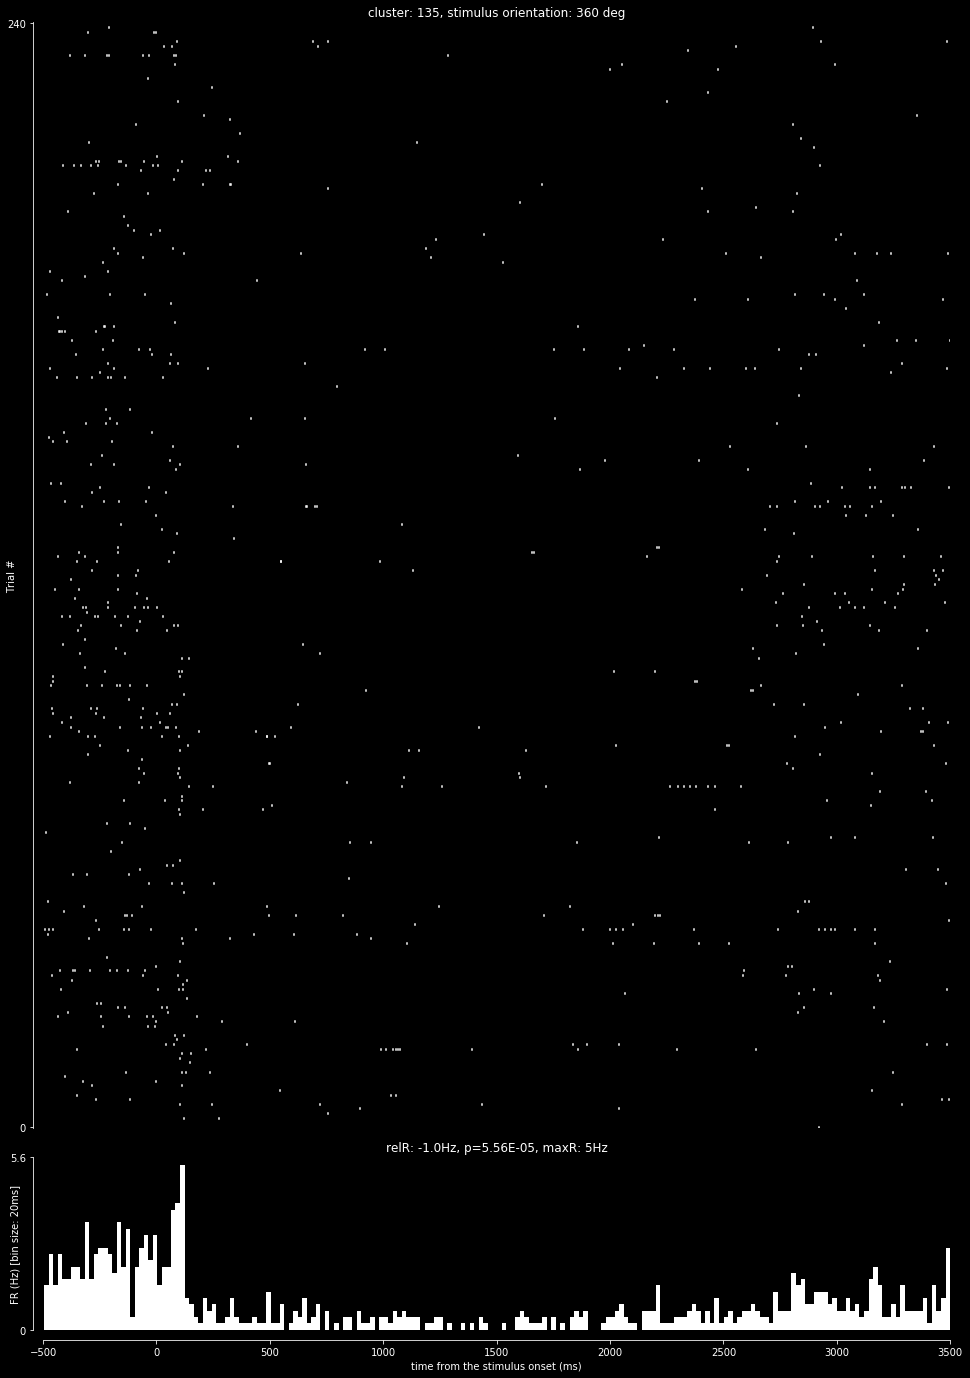

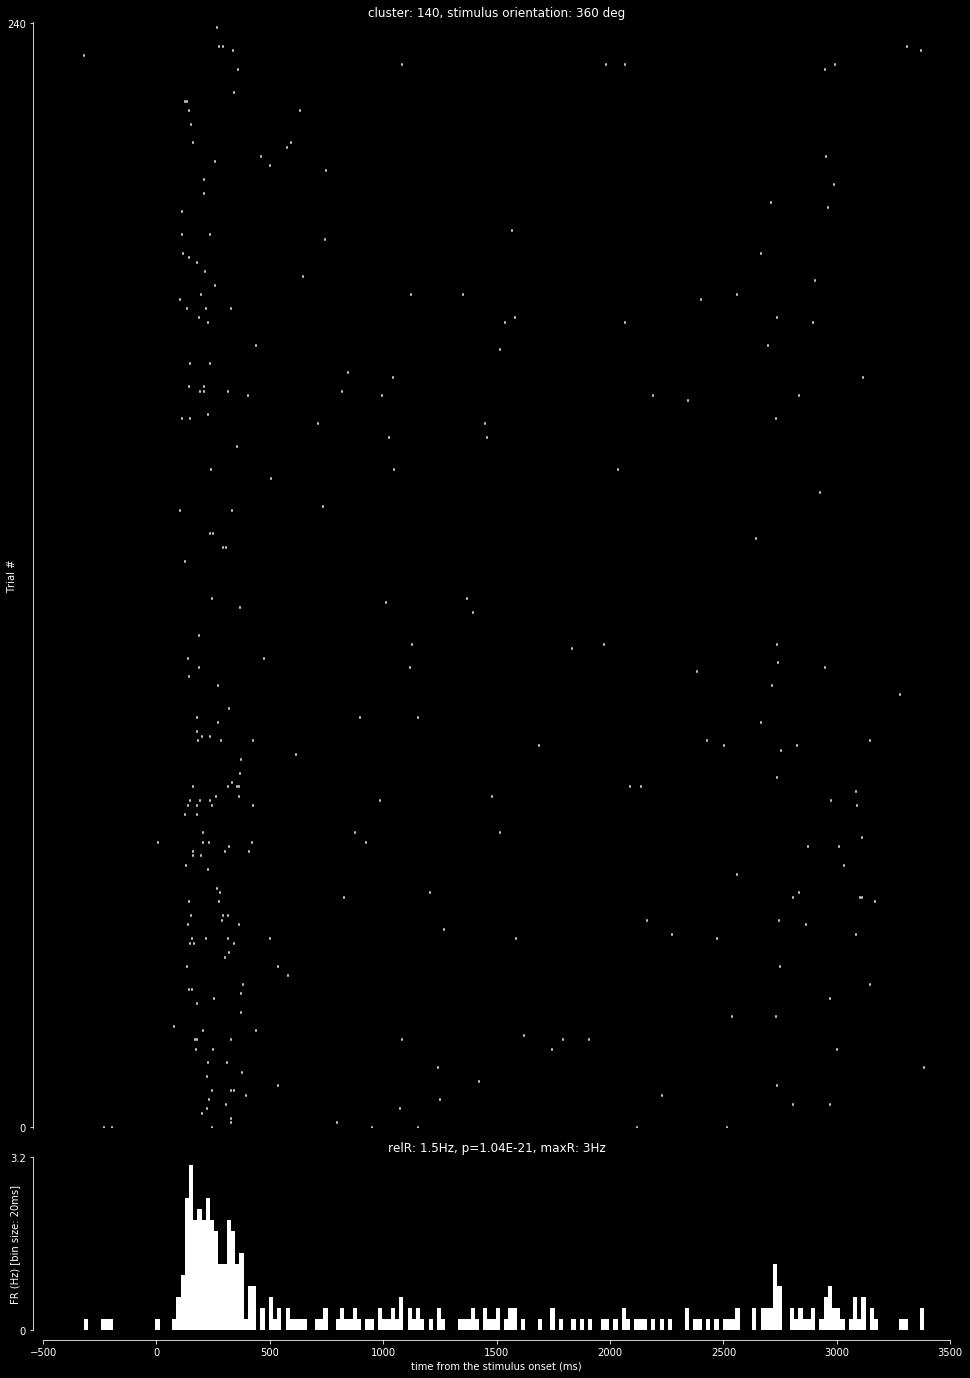

In [16]:
allClustersResponsiveness = []
allClustersBaselineCorrectedResponse = []
allClustersMaxFR_response = []

for clusterNo in spikeClustersToPlot[:]:
    responsiveness, clusterBaselineCorrectedResponse, clusterMaxResponse, clusterResponsivenessPvals = \
        neuronVisualResponse(clusterNo,spikeTime,spikeClusters,stimID,stimOnsetSample, \
                             responseWindowEnd = 3500, darkMode = darkMode);
    
    allClustersResponsiveness.append(responsiveness)
    allClustersBaselineCorrectedResponse.append(clusterBaselineCorrectedResponse)
    allClustersMaxFR_response.append(clusterMaxResponse)

### power Spectrum in L5

#### estimated L5 channel

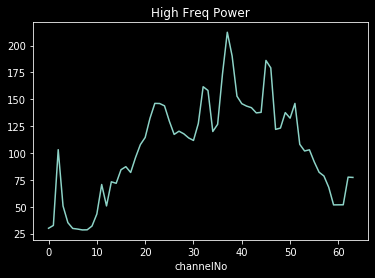

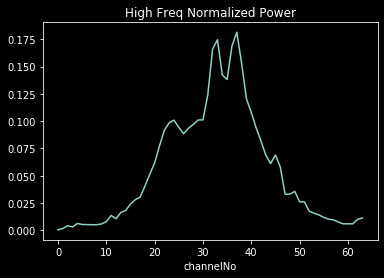

In [17]:
dataFileAddReorderRereferenced = dataFileBaseFolder + '/' + 'amplifierReorderRereferencedMedian.dat'
L5channelNo, allChannelsNormHighFreqPower,\
        allChannelsHighFreqPower = estimatedL5chnnael(dataFileAddReorderRereferenced,\
                                                      firstBeforeStimTagSampleNo)
L4channelNo = L5channelNo - 8
L23channelNo = L5channelNo - 15

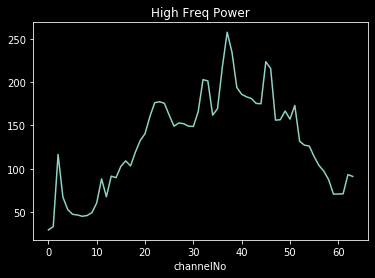

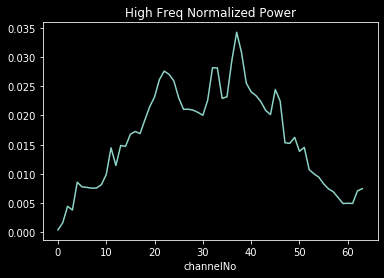

In [18]:
dataFileAddReorderRereferenced = dataFileBaseFolder + '/' + 'amplifierReorder.dat'
L5channelNo, allChannelsNormHighFreqPower,\
        allChannelsHighFreqPower = estimatedL5chnnael(dataFileAddReorderRereferenced,\
                                                      firstBeforeStimTagSampleNo)
L4channelNo = L5channelNo - 8
L23channelNo = L5channelNo - 15

#### reading low pass filtered data file

In [19]:
dataFile = open(dataFileBaseFolder + '/' + 'amplifierReorderRereferencedLowPass.dat' , 'rb')
dataArray = np.fromfile(dataFile,dtype='int16')
dataFile.close()

del dataFile

dataMatrixReorderLowPassFiltered = np.reshape(dataArray, (int(dataArray.shape[0]/channelsNo), channelsNo)).T

del dataArray

#### power spectrum on the channel estimated to be in L5 during spontaneous activity

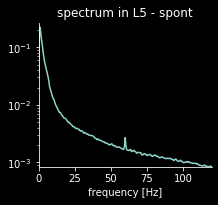

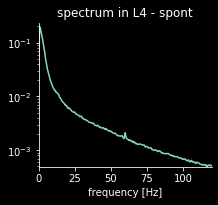

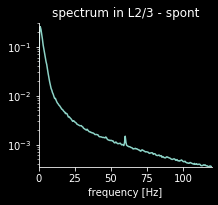

In [20]:
spontEndTime = firstBeforeStimTagSampleNo/fs # in seconds
reducedSamplingRate = 2e3
df = 0.5

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L5channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195

f_powerSpectrum, powerSpectrumL5, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L5 - spont' )

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L4channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195

f, powerSpectrumL4, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L4 - spont' )

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L23channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195

f, powerSpectrumL23, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L2/3 - spont' )

### variables to save

In [21]:
noPupilData = True

In [23]:
# 0 waveshapes
# 1 spikeWidth
# 2 spont FRs
# 3 clusterChannel
# 4 spike-triggered pupil area
# 5 responsiveness 
# 6 baselineCorrectedResponse
# 7 OSI
# 8 Alert OSI
# 9 nonAlert OSI
# 10 relative response Change By Arousal
# 11 basline change by arousal
# 12 evoked-response change by arousal
# 13 best direction response change by arousal
# 14 noise correlation alert
# 15 noise correlation non-alert
# 16 normalized high freq power on all channels
# 17 high freq power on all channels
# 18 power sepctrum L5
# 19 power spectrum L4
# 20 power spectrum L23
# 21 frequency vector
# 22 power spectrum alert L5
# 23 power spectrum non alert L5
# 24 power spectrum alert L4
# 25 power spectrum non alert L4
# 26 power spectrum alert L23
# 27 power spectrum non alert L23

if noPupilData:
    allSpikeTriggeredPupil = []
    OSI_Alert = []
    OSI_nonAlert = []
    allClustersNormalizedArousalResponseChange = []
    allClustersNormalizedArousalBaselineChange = []
    evokedResponseChangeByArousa = []
    bestDirectionRelResponseChangeByArousal = []
    noiseCorrAlert = []
    noiseCorrNonAlert = []
    alertSpectrumL5 = []
    nonAlertSpectrumL5 = []
    alertSpectrumL4 = []
    nonAlertSpectrumL4 = []
    alertSpectrumL23 = []
    nonAlertSpectrumL23 = []
    
if PupBlackWhite:
    allOSI = []
    



animalName = dataFileBaseFolder[len(dataFileBaseFolder) - dataFileBaseFolder[::-1].find('/'):\
                   len(dataFileBaseFolder) - 13]

savingAdd = 'X://Ehsan-temp//Claire-Ehsan_Share//DataToMerge//'

variableToExportToMerge = [spikeShapesFiltered, spikeWidthAll, spontFRs, clusterChannel,\
        allSpikeTriggeredPupil, allClustersResponsiveness, \
        allClustersBaselineCorrectedResponse, allOSI, OSI_Alert, OSI_nonAlert,\
        allClustersNormalizedArousalResponseChange, allClustersNormalizedArousalBaselineChange,\
        evokedResponseChangeByArousa, bestDirectionRelResponseChangeByArousal, noiseCorrAlert, \
        noiseCorrNonAlert, allChannelsNormHighFreqPower, allChannelsHighFreqPower, powerSpectrumL5,\
        powerSpectrumL4, powerSpectrumL23, f_powerSpectrum, alertSpectrumL5, nonAlertSpectrumL5,\
        alertSpectrumL4, nonAlertSpectrumL4, alertSpectrumL23, nonAlertSpectrumL23]

import pickle
pickle.dump(variableToExportToMerge, open(savingAdd+animalName+'.pkl', "wb" ) )